### Configuração do ambiente

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git

!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (151/151), done.
remote: Total 511 (delta 159), reused 124 (delta 91), pack-reused 269 (from 1)
Receiving objects: 100% (511/511), 163.95 KiB | 369.00 KiB/s, done.
Resolving deltas: 100% (261/261), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00
Installing RAPIDS remaining 24.4.* libraries
Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.9/920.9 kB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!nvidia-smi

Thu Oct  3 00:51:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [2]:
BASE_PATH ='/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc'

### Importação de bibliotecas

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import zipfile
# import cudf
# import cupy as cp

import os
from scipy.fft import rfft, rfftfreq

### Obtenção dos dados

In [ ]:
# Download dos arquivos
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip', BASE_PATH + '/data/imbalance.zip')
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/normal.zip', BASE_PATH + '/data/normal.zip')
urllib.request.urlretrieve('https://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/underhang.zip', BASE_PATH + '/data/underhang.zip')

# extração dos arquivos
with zipfile.ZipFile(BASE_PATH + '/data/imbalance.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')
with zipfile.ZipFile(BASE_PATH + '/data/normal.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')
with zipfile.ZipFile(BASE_PATH + '/data/underhang.zip', 'r') as zip_ref:
    zip_ref.extractall(BASE_PATH + 'data')

# excluir arquivos .zip
os.remove(BASE_PATH + '/data/normal.zip')
os.remove(BASE_PATH + '/data/imbalance.zip')
os.remove(BASE_PATH + '/data/underhang.zip')

### Tratamento dos dados

In [189]:
feature_names = ['tacometro', 'rol_int_axial', 'rol_int_radial','rol_int_tangencial',
                 'rol_ext_axial', 'rol_ext_radial','rol_ext_tangencial', 'microfone']

In [190]:
normal_sample = pd.read_csv(BASE_PATH + '/data/normal/61.44.csv', header=None, names=feature_names)
print(normal_sample.dtypes)

tacometro             float64
rol_int_axial         float64
rol_int_radial        float64
rol_int_tangencial    float64
rol_ext_axial         float64
rol_ext_radial        float64
rol_ext_tangencial    float64
microfone             float64
dtype: object


In [22]:
def check_inconsistent_values(path_names):
    for file in path_names:
        data = pd.read_csv(file, header=None)
        nullValues = data.isnull().sum()
        inconsistent_type = data.dtypes != 'float64'
        if any(nullValues > 0):
            print('CSV file {} has null values'.format(file))
        if any(inconsistent_type):
            print('CSV file {} has inconsistent type'.format(file))


normal_file_names = glob.glob(BASE_PATH + '/data/normal/*.csv')
imbalance_file_names = glob.glob(BASE_PATH + '/data/imbalance/**/*.csv')
underhang_files_names = glob.glob(BASE_PATH + '/data/underhang/**/*.csv', recursive=True)

check_inconsistent_values(normal_file_names)
check_inconsistent_values(imbalance_file_names)
check_inconsistent_values(underhang_files_names)

Número de outliers na coluna 0: 44210
Número de outliers na coluna 1: 2100
Número de outliers na coluna 2: 1642
Número de outliers na coluna 3: 2448
Número de outliers na coluna 4: 1813
Número de outliers na coluna 5: 797
Número de outliers na coluna 6: 642
Número de outliers na coluna 7: 390


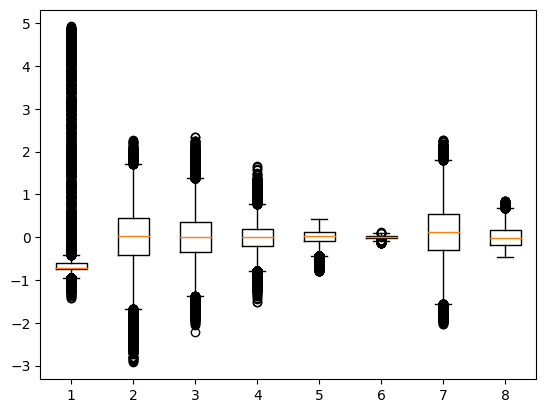

In [191]:

# normal_sample = pd.read_csv(BASE_PATH + '/data/normal/61.44.csv', header=None, names=feature_names)
bp = plt.boxplot(normal_sample)

for feature in range(len(normal_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

In [81]:
def plot_outliers(feature_data, feature_name):
  # Calcular o IQR e identificar outliers
  Q1 = feature_data.quantile(0.25)
  Q3 = feature_data.quantile(0.75)
  IQR = Q3 - Q1
  lower_limit_outliers = Q1 - 1.5 * IQR
  upper_limit_outliers = Q3 + 1.5 * IQR
  outliers = (feature_data < lower_limit_outliers) | (feature_data > upper_limit_outliers)

  # reduzir quantidade de dados para melhor visualização
  sample_size = len(feature_data) // 10
  sample_data = feature_data[:sample_size]
  sample_outliers = outliers[:sample_size]

  # Plotar a série temporal e destacar os outliers e limites dos dados considerados outliers
  plt.figure(figsize=(12, 6))
  plt.plot(sample_data, label='Dados')
  plt.scatter(sample_data.index[sample_outliers], sample_data[sample_outliers], color='red', label='Outliers')
  plt.axhline(y=lower_limit_outliers, color='blue', linestyle='--', label='Limite inferior outliers')
  plt.axhline(y=upper_limit_outliers, color='green', linestyle='--', label='Limite Superior outliers')
  plt.title(f'Dados do {feature_name} com Outliers Destacados')
  plt.xlabel('Amostras')
  plt.ylabel('Valores')
  plt.legend(loc='upper right')
  plt.show()

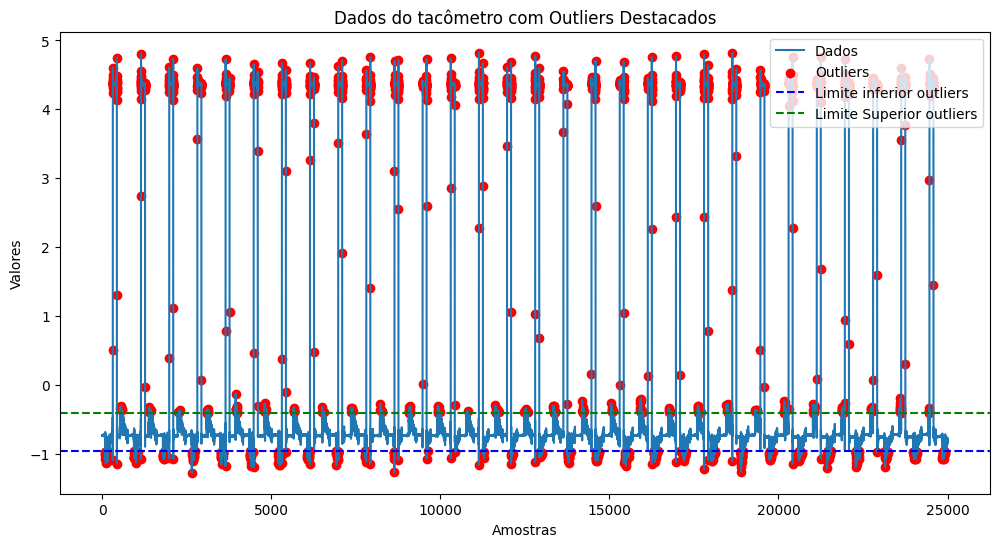

In [182]:
feature_data = normal_sample['tacometro']
plot_outliers(feature_data, 'tacômetro')


In [61]:
normal_sample[0].median()

-0.72733

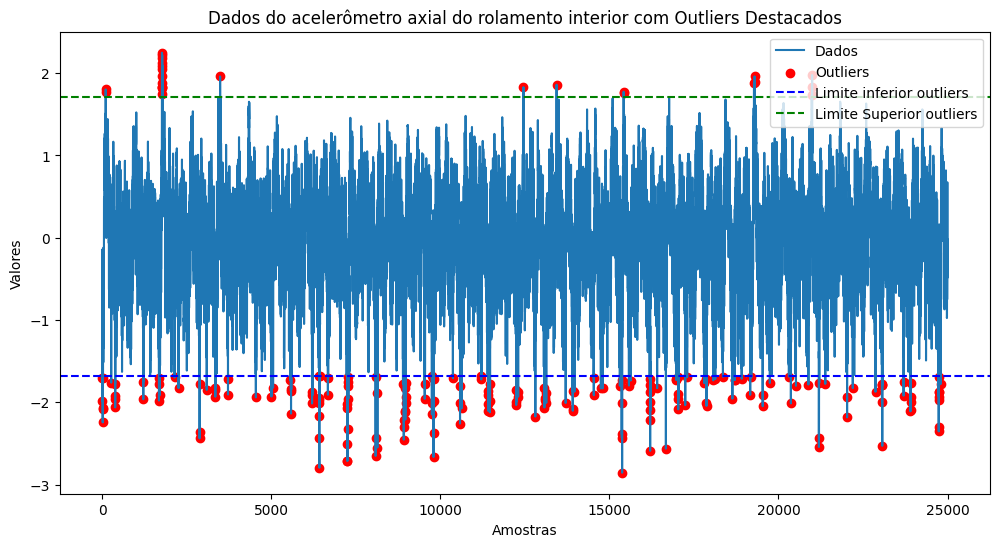

In [183]:
feature_data = normal_sample['rol_int_axial']
plot_outliers(feature_data, 'acelerômetro axial do rolamento interior')

In [21]:

def check_outliers(df, colunas, limiar=3):
  outliers = pd.DataFrame()
  for coluna in colunas:
    media = np.mean(df.iloc[:, coluna])
    desvio_padrao = np.std(df.iloc[:, coluna])
    z_scores = np.abs((df.iloc[:, coluna] - media) / desvio_padrao)
    outliers_coluna = df[z_scores > limiar]
    outliers = pd.concat([outliers, outliers_coluna])
  return outliers

outliers = check_outliers(normal_sample, range(0,7))
print(outliers)

0.0020609014505184
              0         1        2         3         4         5         6  \
10     -0.72834 -1.981800  0.40530 -0.560410 -0.007304 -0.037043 -0.420770   
17     -0.72602 -2.065200  1.09240 -0.220730  0.030787 -0.024343 -0.068778   
19     -0.73446 -2.244800  0.63329 -0.790740  0.049271 -0.016353  0.073615   
21     -0.74046 -2.077400  0.54913 -0.279390  0.073124 -0.007651  0.089335   
387     4.37520 -1.920500 -0.82435 -0.284080  0.185930  0.015773  0.392370   
...         ...       ...      ...       ...       ...       ...       ...   
249786 -0.59537 -0.458330 -0.38979 -0.294960 -0.033571  0.021318 -1.812000   
249787 -0.46764 -0.118270 -0.13613 -0.064998 -0.034939  0.022043 -1.797500   
249788 -0.72486 -0.658050 -0.49247  0.150400 -0.040957  0.021876 -1.764000   
249789 -0.42135 -0.057422 -0.43172  0.345460 -0.047726  0.020015 -1.740900   
249873 -0.53866 -0.142660 -0.55310  0.075086 -0.067295 -0.027468 -1.724800   

               7  
10      0.357620  
17    

Foram identificados outliers, uma tecnica que pode ser utilizada para tratamento destes outliers é com suavisação com media móvel. Entretanto, como veremos mais a frente, será feito um resample dos dados, utilizando a mesma tecnica de media movel, assim estes outliers ja serão tratados juntamente com o resample.

Número de outliers na coluna 0: 38410
Número de outliers na coluna 1: 85
Número de outliers na coluna 2: 399
Número de outliers na coluna 3: 1058
Número de outliers na coluna 4: 251
Número de outliers na coluna 5: 132
Número de outliers na coluna 6: 1684
Número de outliers na coluna 7: 2386


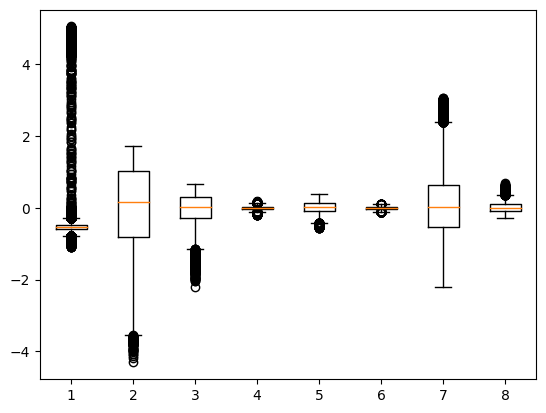

In [233]:
imbalance_sample = pd.read_csv(BASE_PATH + '/data/imbalance/15g/13.312.csv', header=None, names=feature_names)

bp = plt.boxplot(imbalance_sample)

for feature in range(len(imbalance_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

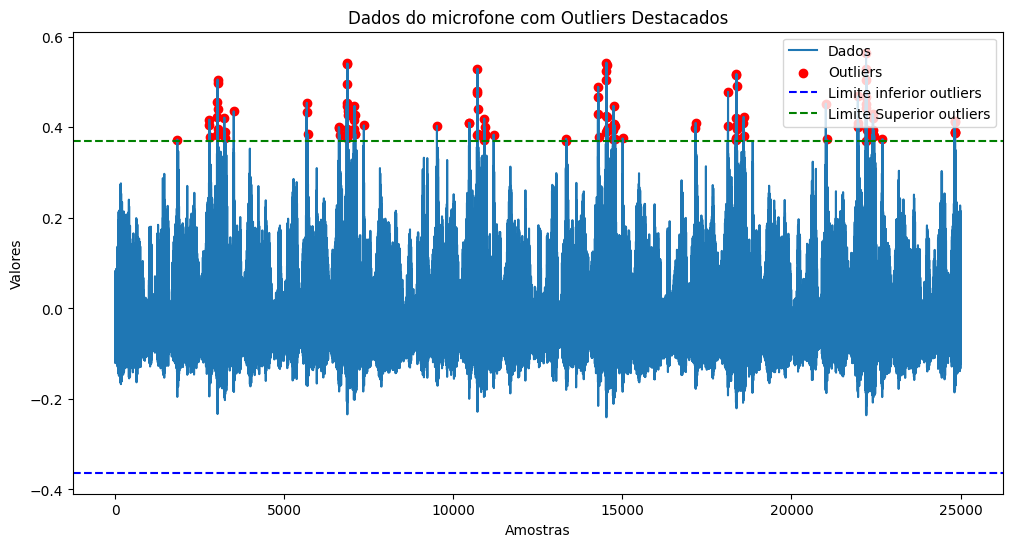

In [185]:
feature_data = imbalance_sample['microfone']
plot_outliers(feature_data, 'microfone')

Número de outliers na coluna 0: 38397
Número de outliers na coluna 1: 2927
Número de outliers na coluna 2: 1126
Número de outliers na coluna 3: 324
Número de outliers na coluna 4: 14
Número de outliers na coluna 5: 12474
Número de outliers na coluna 6: 0
Número de outliers na coluna 7: 1115


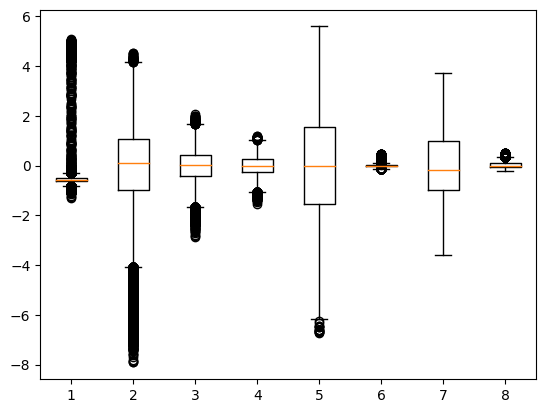

In [193]:
underhang_sample = pd.read_csv(BASE_PATH + '/data/underhang/ball_fault/20g/15.36.csv', header=None, names=feature_names)

bp = plt.boxplot(underhang_sample)

for feature in range(len(underhang_sample.columns)):
    # Obter os outliers (fliers)
    outliers = bp['fliers'][feature].get_ydata()

    # Contar os outliers
    num_outliers = len(outliers)

    # Imprimir o número de outliers para a feature
    print(f"Número de outliers na coluna {feature}: {num_outliers}")

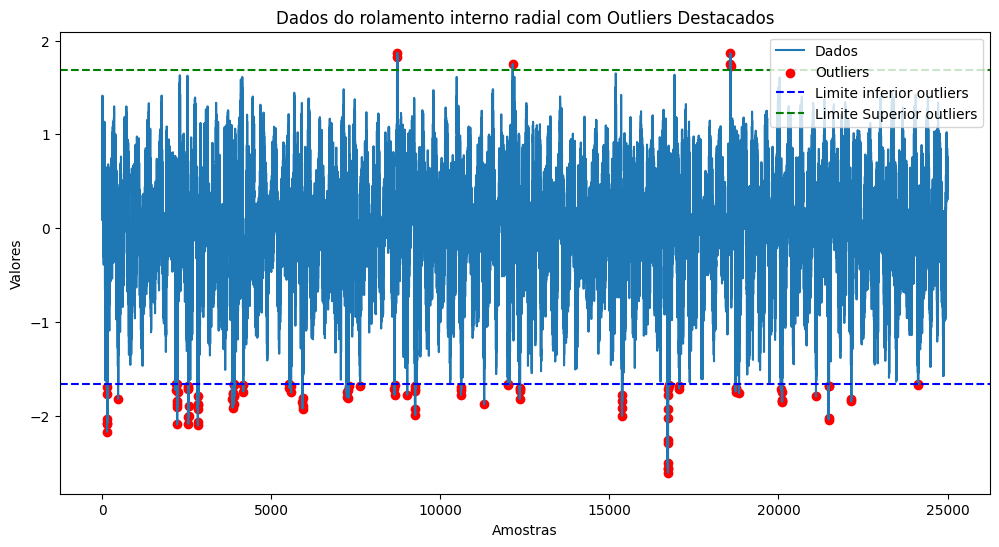

In [194]:
feature_data = underhang_sample['rol_int_radial']
plot_outliers(feature_data, 'rolamento interno radial')

# Análise e exploração dos dados

In [226]:
normal_sample.head()

tacometro  rol_int_axial  rol_int_radial  rol_int_tangencial  \
0   -0.73677       -0.81027         0.15131            0.265130   
1   -0.73709       -1.25840        -0.91427            0.233290   
2   -0.72662       -0.39682         0.54628            0.222700   
3   -0.74232       -0.83926        -0.57734           -0.076713   
4   -0.72715       -0.14363         0.53314           -0.477420   

   rol_ext_axial  rol_ext_radial  rol_ext_tangencial  microfone  
0      -0.028902       -0.034116             0.31677   -0.12103  
1      -0.046288       -0.037319             0.26041    0.18275  
2      -0.004793       -0.029894             0.61730   -0.28536  
3      -0.030071       -0.036934             0.42859    0.26604  
4      -0.011421       -0.033314             0.52157   -0.29378

In [225]:
normal_sample.dtypes

tacometro             float64
rol_int_axial         float64
rol_int_radial        float64
rol_int_tangencial    float64
rol_ext_axial         float64
rol_ext_radial        float64
rol_ext_tangencial    float64
microfone             float64
dtype: object

In [223]:
normal_sample.describe()

tacometro  rol_int_axial  rol_int_radial  rol_int_tangencial  \
count  250000.000000  250000.000000   250000.000000       250000.000000   
mean       -0.000037       0.002061       -0.000348            0.000613   
std         1.785603       0.627288        0.505619            0.295160   
min        -1.422500      -2.925600       -2.204000           -1.523700   
25%        -0.751900      -0.411782       -0.346573           -0.196170   
50%        -0.727330       0.020503        0.003436            0.001267   
75%        -0.612957       0.436710        0.344320            0.196390   
max         4.920500       2.280700        2.343100            1.658800   

       rol_ext_axial  rol_ext_radial  rol_ext_tangencial      microfone  
count  250000.000000   250000.000000       250000.000000  250000.000000  
mean        0.008205        0.002906            0.115704       0.011230  
std         0.164101        0.036356            0.593672       0.215691  
min        -0.800550       -0.129330           -2.025200      -0.472960  
25%        -0.098271       -0.021795           -0.300280      -0.171240  
50%         0.024407        0.003843            0.130430      -0.007933  
75%         0.128650        0.029070            0.537680       0.172360  
max         0.432870        0.109660            2.273500       0.849900

In [222]:
imbalance_sample.describe()

tacometro  rol_int_axial  ro_int_radial  rol_int_tangencial  \
count  250000.000000  250000.000000  250000.000000       250000.000000   
mean       -0.000499       0.016254       0.000103            0.000779   
std         1.585844       1.097578       0.344077            0.046907   
min        -1.100600      -4.306500      -2.199100           -0.210420   
25%        -0.597430      -0.812285      -0.272703           -0.031125   
50%        -0.541110       0.167840       0.036446            0.003702   
75%        -0.467618       1.013100       0.315230            0.034056   
max         5.050500       1.715800       0.652900            0.182490   

       rol_ext_axial  rol_ext_radial  rol_ext_tangencial      microfone  
count  250000.000000   250000.000000       250000.000000  250000.000000  
mean        0.009088        0.003904            0.085726       0.012278  
std         0.146979        0.038289            0.860979       0.124477  
min        -0.553140       -0.127340           -2.193000      -0.277910  
25%        -0.093604       -0.023014           -0.534610      -0.087956  
50%         0.012660        0.004068            0.017542      -0.011705  
75%         0.122940        0.031105            0.637223       0.095406  
max         0.372050        0.119940            3.056400       0.683360

In [221]:
underhang_sample.describe()

tacometro  rol_int_axial  rol_int_radial  rol_int_tangencial  \
count  250000.000000  250000.000000   250000.000000       250000.000000   
mean       -0.000825       0.004045       -0.000616           -0.000245   
std         1.620201       1.538240        0.602366            0.356580   
min        -1.299200      -7.911700       -2.851800           -1.521400   
25%        -0.624820      -0.974453       -0.404010           -0.260110   
50%        -0.570330       0.104855        0.024565           -0.006029   
75%        -0.493130       1.083400        0.433737            0.262930   
max         5.078100       4.545400        2.067800            1.205700   

       rol_ext_axial  rol_ext_radial  rol_ext_tangencial      microfone  
count  250000.000000   250000.000000       250000.000000  250000.000000  
mean        0.006261        0.001888           -0.015612       0.018107  
std         1.990002        0.059382            1.193174       0.106651  
min        -6.712300       -0.147010           -3.607200      -0.218650  
25%        -1.534800       -0.033763           -0.974683      -0.072574  
50%        -0.003913       -0.005680           -0.164970       0.003239  
75%         1.568125        0.023532            0.980860       0.096288  
max         5.594700        0.461760            3.738400       0.519590

from matplotlib import pyplot as plt
_df_0['tacometro'].plot(kind='hist', bins=20, title='tacometro')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['rol_int_axial'].plot(kind='hist', bins=20, title='rol_int_axial')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['rol_int_radial'].plot(kind='hist', bins=20, title='rol_int_radial')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['rol_int_tangencial'].plot(kind='hist', bins=20, title='rol_int_tangencial')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='tacometro', y='rol_int_axial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='rol_int_axial', y='rol_int_radial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='rol_int_radial', y='rol_int_tangencial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='rol_int_tangencial', y='rol_ext_axial', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['tacometro'].plot(kind='line', figsize=(8, 4), title='tacometro')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['rol_int_axial'].plot(kind='line', figsize=(8, 4), title='rol_int_axial')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['rol_int_radial'].plot(kind='line', figsize=(8, 4), title='rol_int_radial')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['rol_int_tangencial'].plot(kind='line', figsize=(8, 4), title='rol_int_tangencial')
plt.gca().spines[['top', 'right']].set_visible(False)

In [232]:
normal_sample.std()

tacometro             1.785603
rol_int_axial         0.627288
rol_int_radial        0.505619
rol_int_tangencial    0.295160
rol_ext_axial         0.164101
rol_ext_radial        0.036356
rol_ext_tangencial    0.593672
microfone             0.215691
dtype: float64

In [247]:
comparative_std = pd.DataFrame({ 'Normal': normal_sample.std(), 'Desbalanceado': imbalance_sample.std(), 'Rolamento inferior': underhang_sample.std()})
comparative_std.style.background_gradient(cmap='Blues')

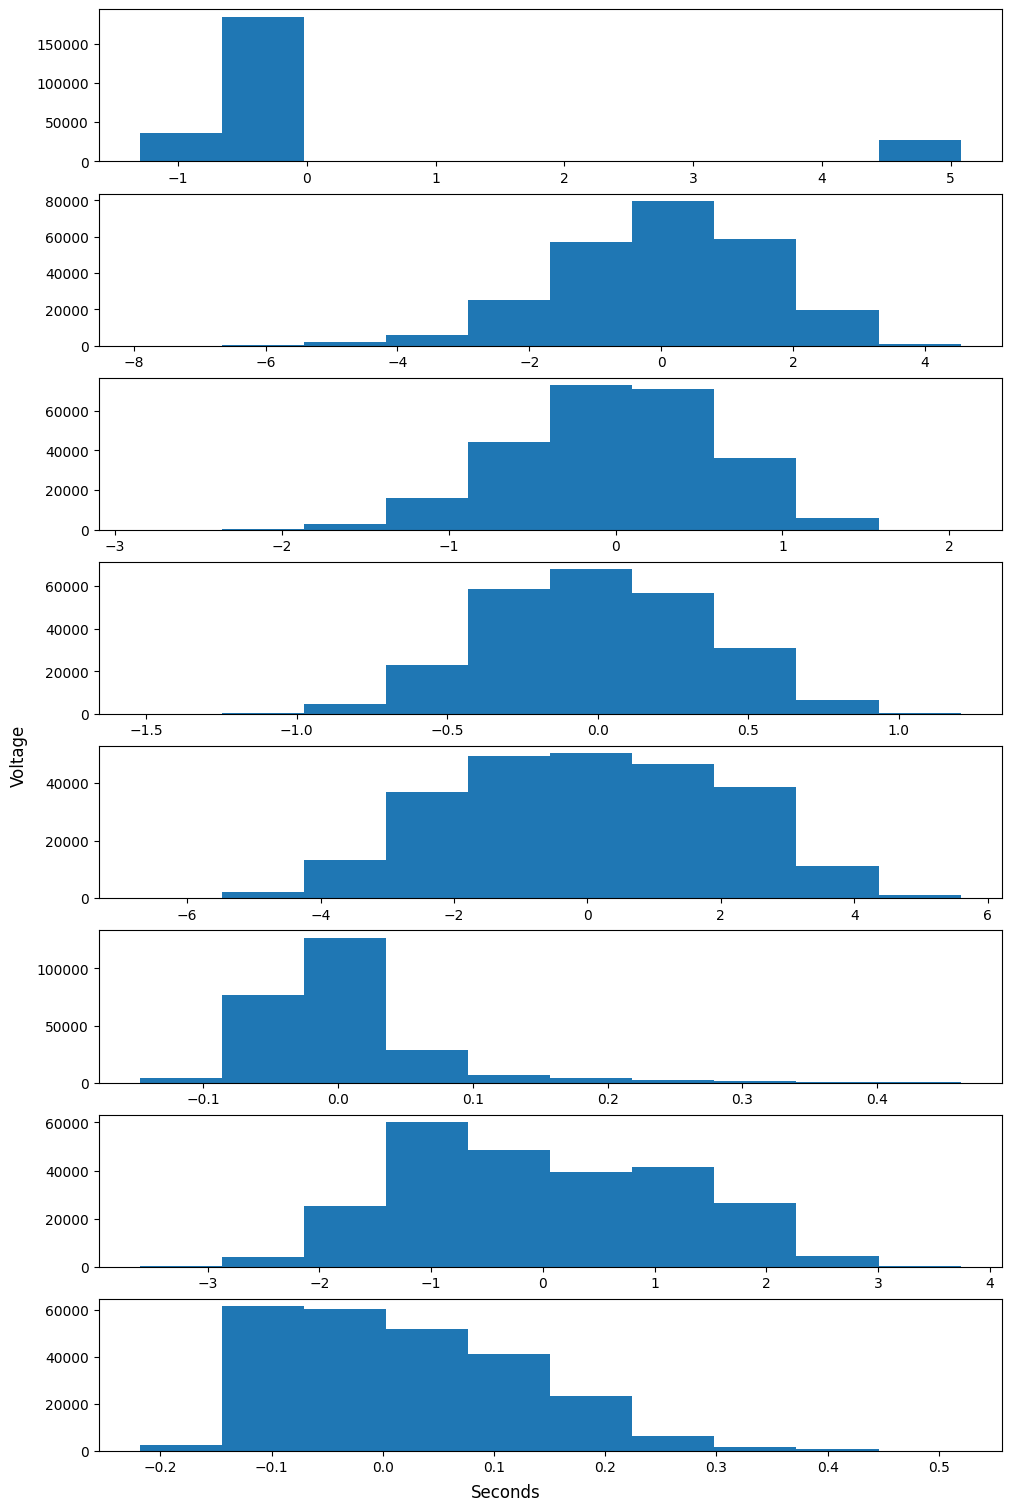

In [257]:
def plotHistogram(data):
    timeAxes = np.arange(0 ,5, 1/50000)
    figure, axis = plt.subplots(8,1, figsize=(10,15),  constrained_layout=True)
    for i in range(len(data.columns)):
        axis[i].hist(data.iloc[:,i])

    figure.supxlabel('Seconds')
    figure.supylabel('Voltage')

plotHistogram(underhang_sample)

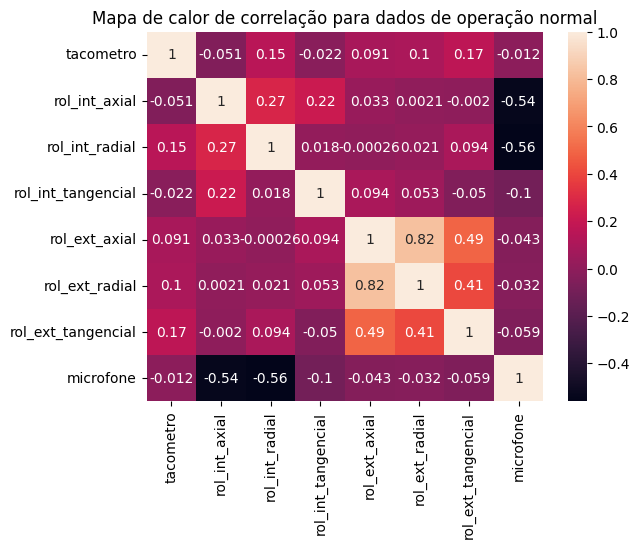

In [239]:
correlation_matrix = normal_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax =sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação normal')
plt.show()

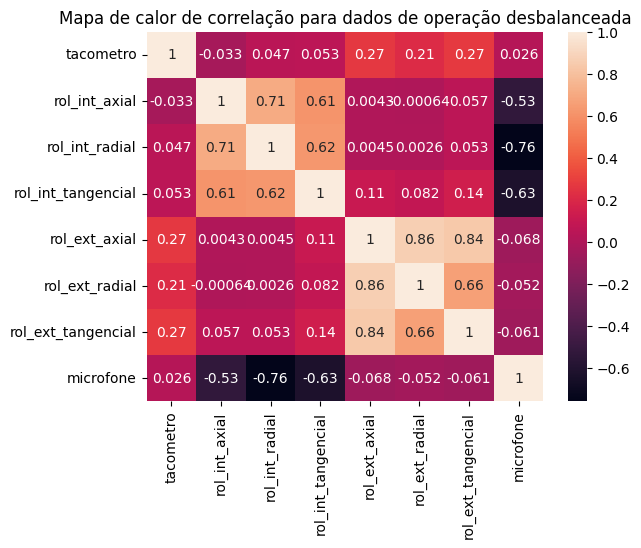

In [243]:
correlation_matrix = imbalance_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax = sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação desbalanceada')
plt.show()

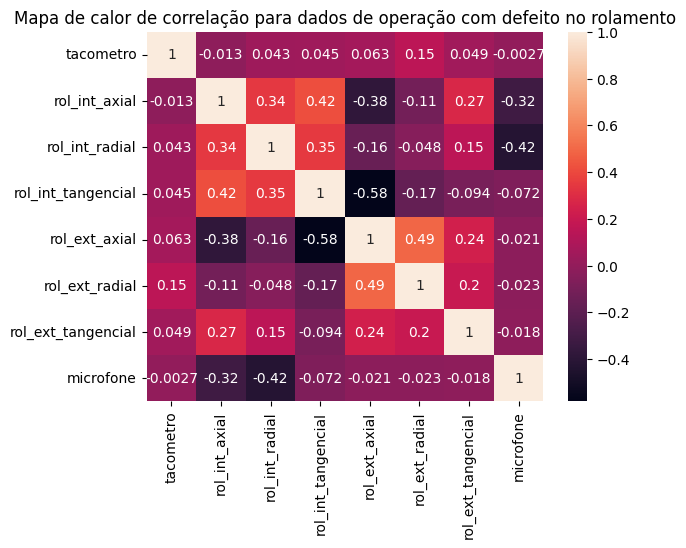

In [244]:
correlation_matrix = underhang_sample.corr()

# Plotar a matriz de correlação como um heatmap
ax = sns.heatmap(correlation_matrix, annot=True)
ax.set_title('Mapa de calor de correlação para dados de operação com defeito no rolamento')
plt.show()

In [ ]:
def dataReader(path_names):
    data = []
    for i in path_names:
        data_file = pd.read_csv(i,header=None)
        data.append(data_file)
    return np.array(data)

In [170]:
normal_sample.columns

Index(['tacometro', 'rolamento interno axial', 'rolamento interno radial',
       'rolamento interno tangencial', 'rolamento externo axial',
       'rolamento externo radial', 'rolamento externo tangencial',
       'microfone'],
      dtype='object')

In [215]:
def plotSignalSample(data, title):
    timeAxes = np.arange(0 , 1, 1/50000)
    data_1s = data[0:50000]
    figure, axis = plt.subplots(8,1, figsize=(10,15),  constrained_layout=True)
    plt.title(title)

    for i in range(len(data.columns)):
        axis[i].set_title(data.columns[i])
        axis[i].plot(timeAxes, data_1s.iloc[:,i])

    figure.suptitle(title, fontsize=18)
    figure.supxlabel('Seconds')
    figure.supylabel('Voltage')


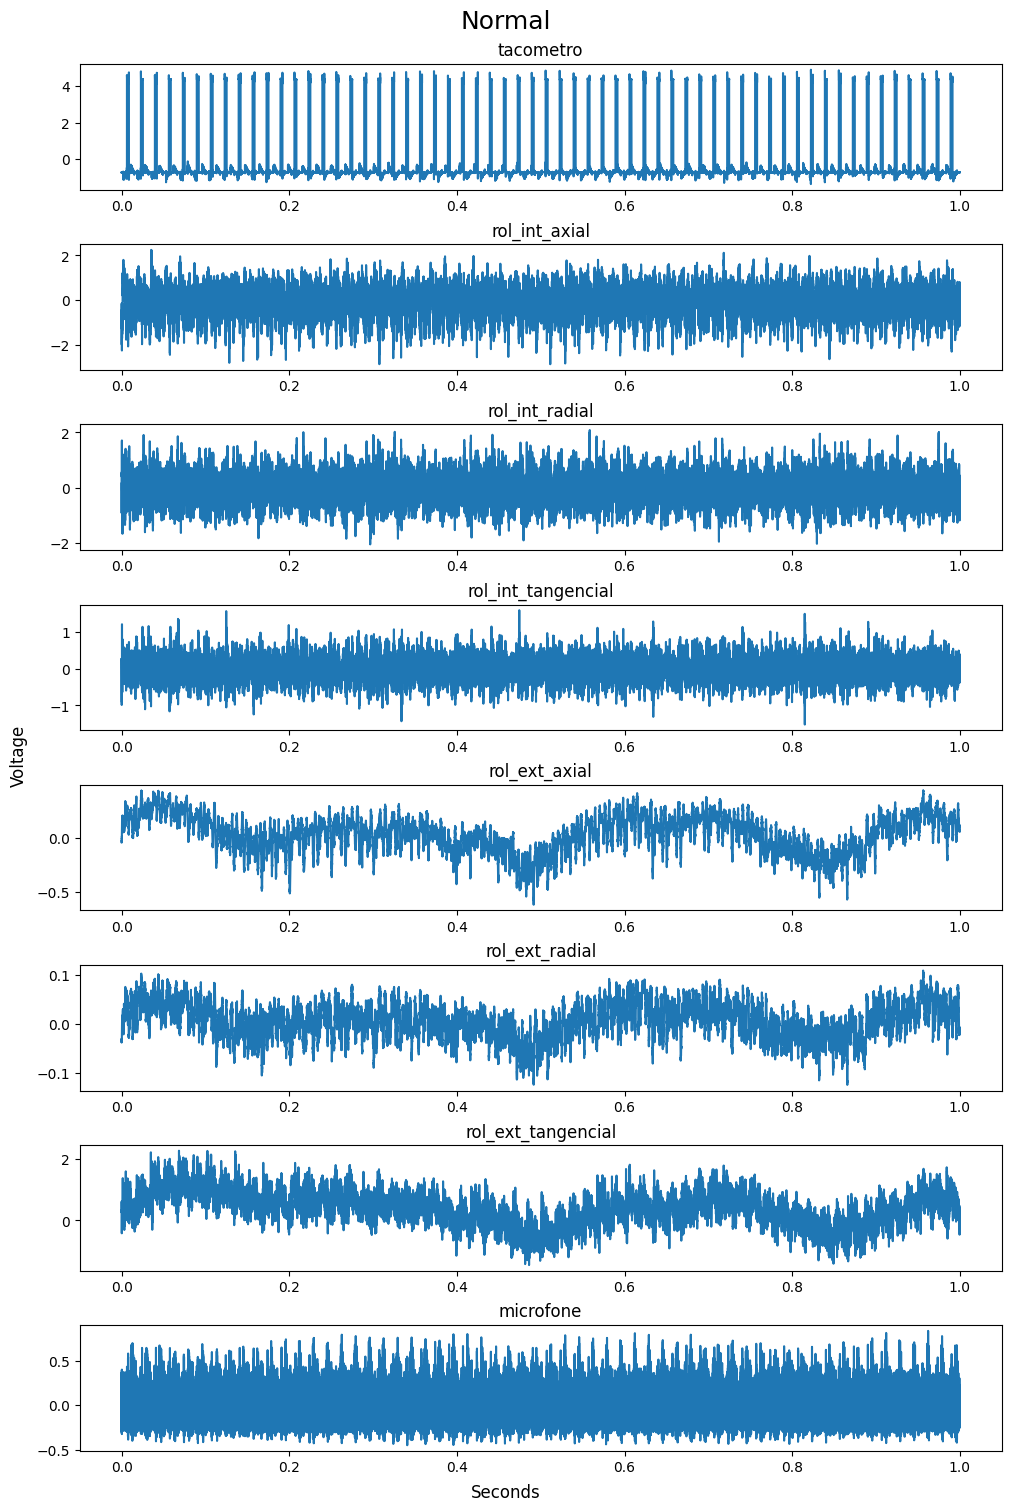

In [216]:
plotSignalSample(normal_sample, 'Normal')


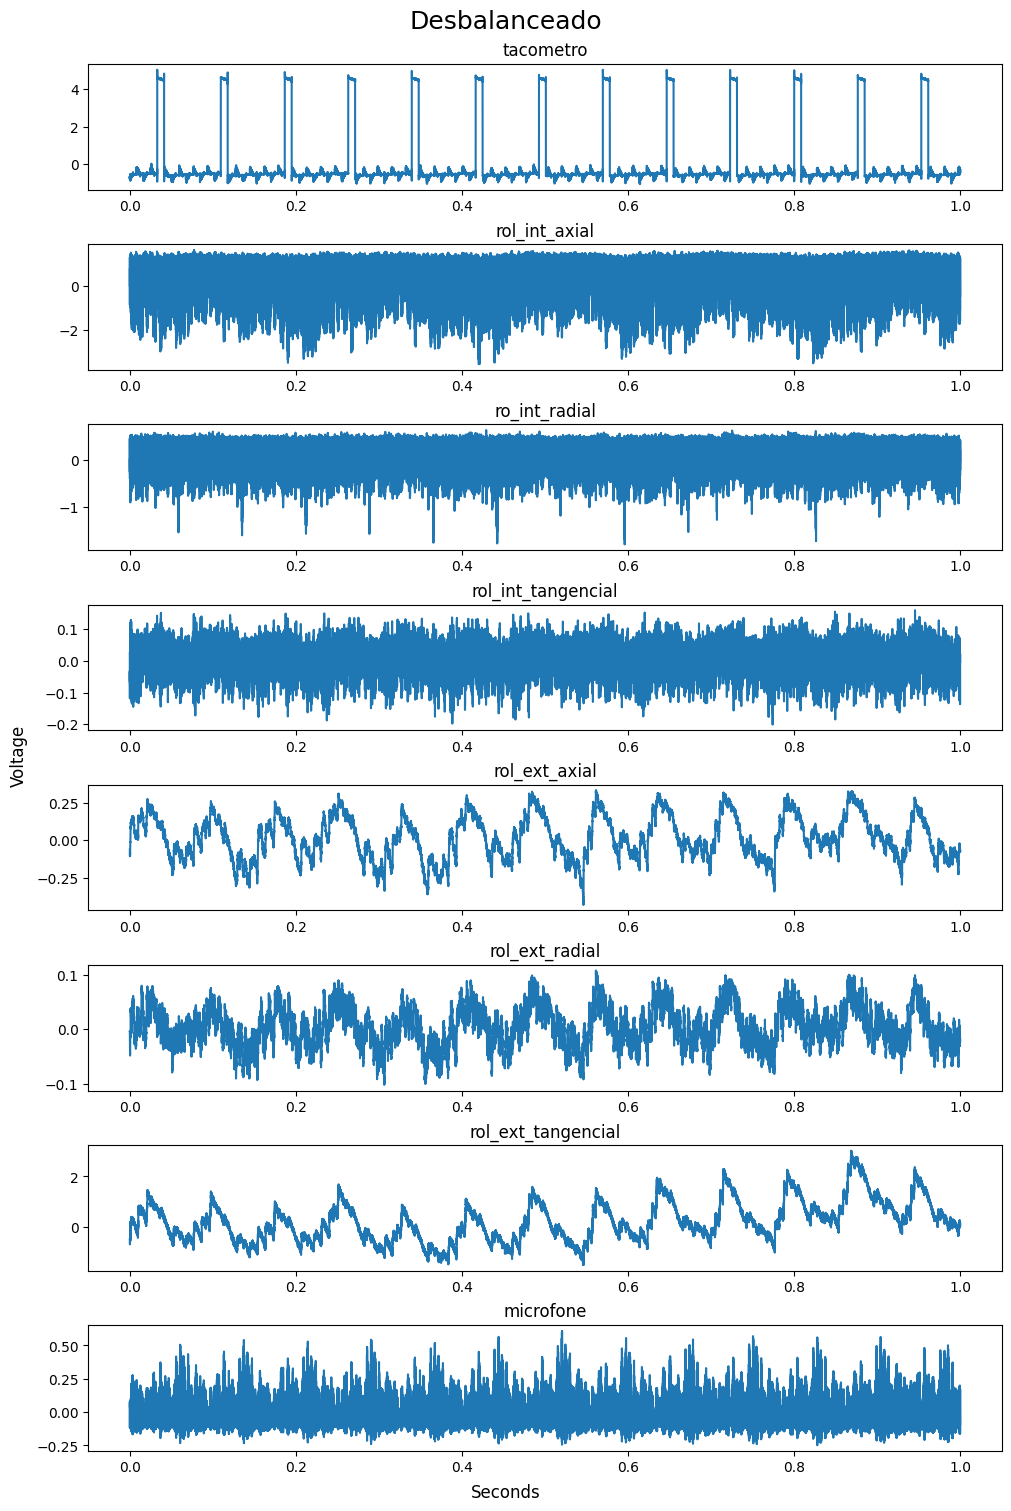

In [217]:
plotSignalSample(imbalance_sample, 'Desbalanceado')

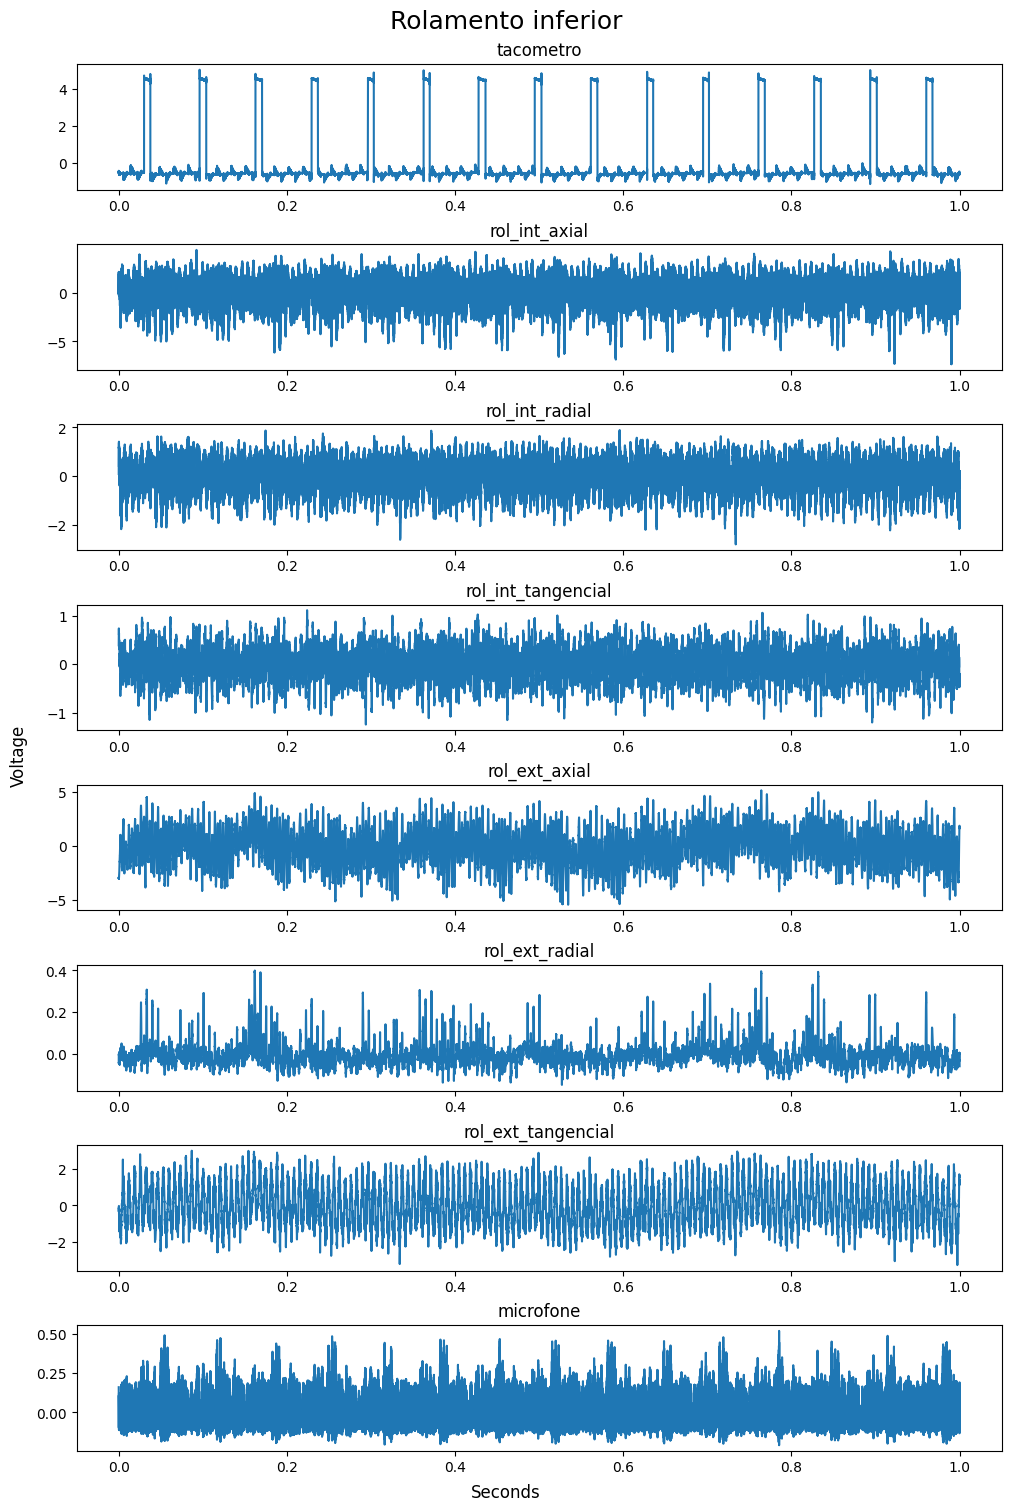

In [218]:
plotSignalSample(underhang_sample, 'Rolamento inferior')

Deste gráfico chegamos a 2 conclusões:
- Dados não estão na mesma escala, o que pode enviesar o algoritmo de machine learn.
- Alta taxa de amostragem (50kHz), o que tornará o processo de treinamento muito lento.

# Resample


In [22]:
ORIGINAL_SAMPLE_RATE = 50000 # taxa de amostragem original dos dados

In [23]:
def apply_rfft(signal, sampling_rate):
    """
    Aplica a Transformada Rápida de Fourier Real (RFFT) a um sinal de entrada.

    Parâmetros:
    signal (numpy array): O sinal de entrada.
    sampling_rate (float): A taxa de amostragem do sinal.

    Retorna:
    tuple: Frequências e coeficientes da RFFT.
    """
    rfft_result = np.abs(np.fft.rfft(signal, axis=0))[1:,:]
    rfft_freqs = np.fft.rfftfreq(len(signal), d=1/sampling_rate)[1:]

    return rfft_result, rfft_freqs

percentil 98: 346.6660781346594


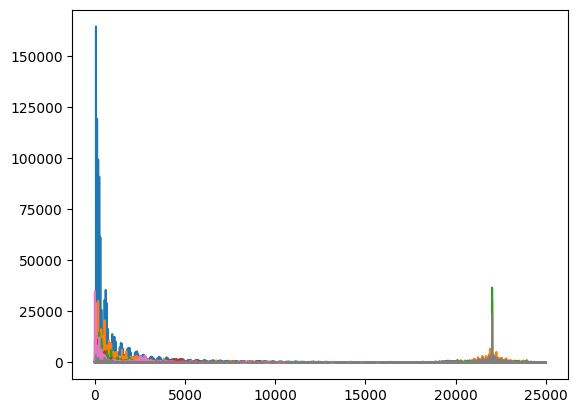

In [ ]:
sample_normal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/normal/61.44.csv', header=None)
sample_normal_fft, sample_normal_fft_freq = apply_rfft(sample_normal, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_normal_fft_freq, sample_normal_fft)
print(f'percentil 98: {np.percentile(sample_normal_fft, 98)}')

percentil 98: 98.58981355431499


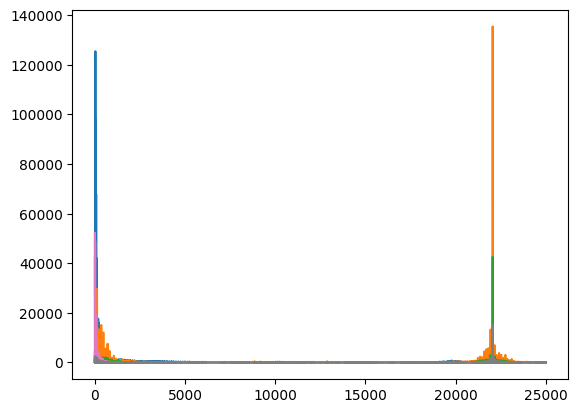

In [ ]:
sample_imbalance = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/imbalance/30g/14.336.csv', header=None)
sample_imbalance_fft, sample_imbalance_fft_freq = apply_rfft(sample_imbalance, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_imbalance_fft_freq, sample_imbalance_fft)
print(f'percentil 98: {np.percentile(sample_imbalance_fft, 95)}')


percentil 99: 202.00717560364367


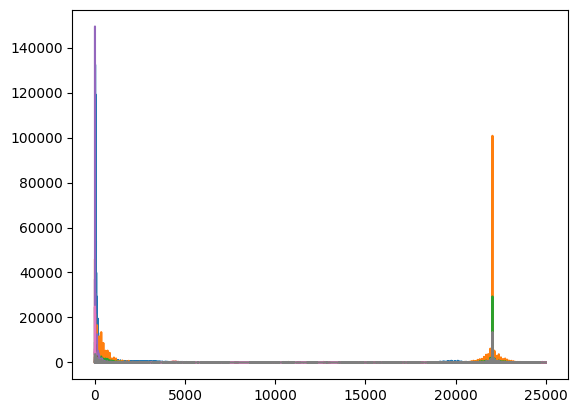

In [ ]:
sample_horizontal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/horizontal-misalignment/1.0mm/12.288.csv', header=None)
sample_horizontal_fft, sample_horizontal_fft_freq = apply_rfft(sample_horizontal, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_horizontal_fft_freq, sample_horizontal_fft)
print(f'percentil 98: {np.percentile(sample_horizontal_fft, 98)}')


percentil 99: 215.8395349824679


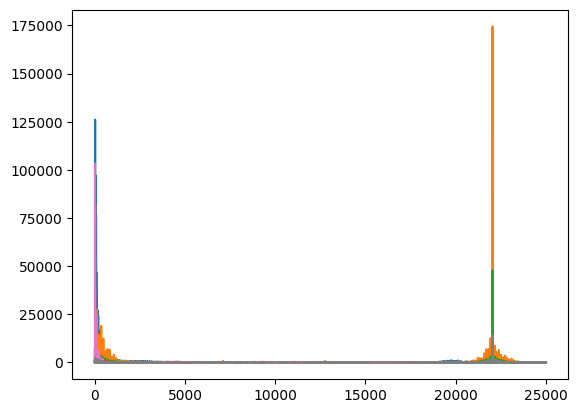

In [ ]:
sample_vertical = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/vertical-misalignment/1.40mm/13.312.csv', header=None)
sample_vertical_fft, sample_vertical_fft_freq = apply_rfft(sample_vertical, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_vertical_fft_freq, sample_vertical_fft)
print(f'percentil 98: {np.percentile(sample_vertical_fft, 98)}')

percentil 99: 176.59558903716473


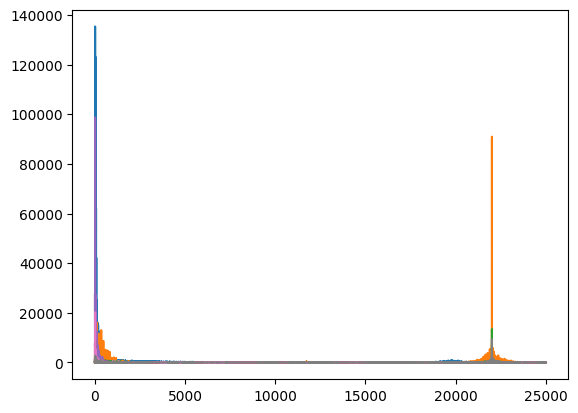

In [ ]:
sample_overhang = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/overhang/cage_fault/6g/13.1072.csv', header=None)
sample_overhang_fft, sample_overhang_fft_freq = apply_rfft(sample_overhang, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_overhang_fft_freq, sample_overhang_fft)
print(f'percentil 98: {np.percentile(sample_overhang_fft, 98)}')

percentil 99: 235.0750181101565


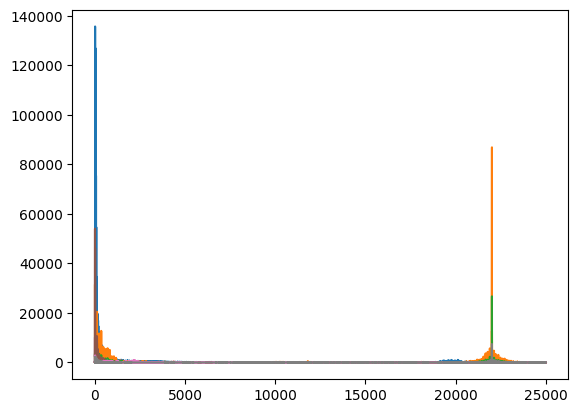

In [ ]:
sample_underhang = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/underhang/outer_race/20g/12.9024.csv', header=None)
sample_underhang_fft, sample_underhang_fft_freq = apply_rfft(sample_underhang, ORIGINAL_SAMPLE_RATE)
plt.plot(sample_underhang_fft_freq,sample_underhang_fft)
print(f'percentil 98: {np.percentile(sample_underhang_fft, 98)}')

In [24]:
target_rate = 700


In [ ]:
def resample(data, sample_target_rate, qtt_series=1):
    data_resampled = []
    period = 5 * qtt_series # seconds
    step = int(len(data)/period / sample_target_rate )
    start_index = 0
    stop_index = step
    for i in range(0, len(data), step):
        temp = data[start_index:stop_index].mean(axis=0)
        data_resampled.append(temp)
        start_index += step
        stop_index += step

    return np.array(data_resampled)


In [ ]:
# normalSample = pd.read_csv('./data/normal/61.44.csv', header=None)
a = sample_normal.to_numpy()
normal_sample_resampled = resample(a, target_rate)
# imbalance6gSampleResampled = resample(imbalance6gSample, target_rate)
normal_sample_resampled.shape

(2500, 8)

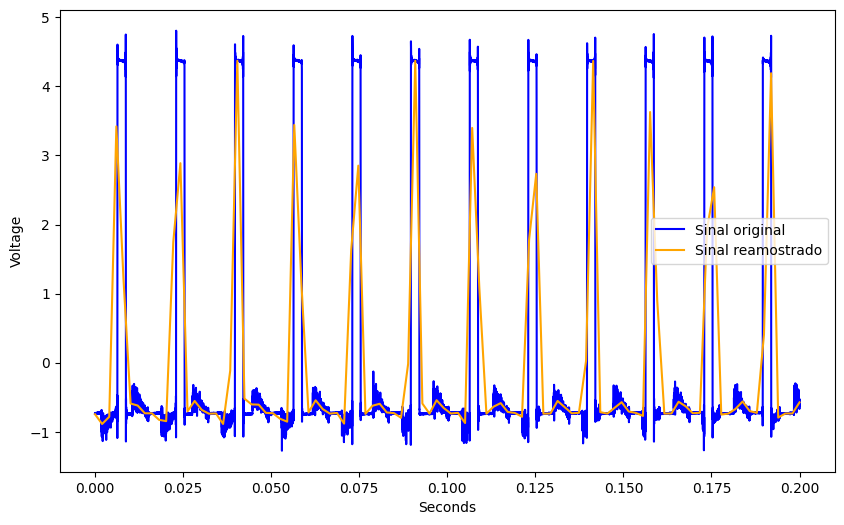

In [ ]:
# plot 0,2s dos dados originais e reamostrados para comparação
# usado valor 10000 e 100, pois é 1/5 da taxa de amostragem original. pois esta sendo plotado 0,2s (1/5 de segundo)
time = 0.2 # s
qty_original_samples =  int(ORIGINAL_SAMPLE_RATE * time)
qty_resampled_sample = int(target_rate * time)
t1 = np.linspace(0, time, qty_original_samples)
t2 = np.linspace(0, time, qty_resampled_sample)
plt.figure(figsize=(10, 6))
plt.plot(t1,  sample_normal[0][0:qty_original_samples], label='Sinal original', color='blue')
plt.plot(t2,  normal_sample_resampled[0][0:qty_resampled_sample], label='Sinal reamostrado', color='orange')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.legend()


podemos observar que há perdas nos dados. Será testado diferentes frequencias de reamostragem para encontrar o melhor  trade-off entre a precisão dos dados e o custo de treinamento.

modelos que podem ser usados
LSTM
dnn
knn
svm


In [21]:
def resample_signal(signal, original_sampling_rate, new_sampling_rate):
    # Vetor de tempo original
    t_original = np.arange(0, signal.shape[0]) / original_sampling_rate

    # Vetor de tempo para o sinal reamostrado
    # Calculate the duration of the original signal
    original_duration = signal.shape[0] / original_sampling_rate
    # Create the new time vector based on the original duration
    t_new = np.arange(0, original_duration, 1/new_sampling_rate)

    # Inicializar o array para o sinal reamostrado
    resampled_signal = np.zeros((len(t_new), signal.shape[1]))

    # Aplicar interpolação em cada coluna
    for i in range(signal.shape[1]):
         resampled_signal[:, i] = np.interp(t_new, t_original, signal[:, i])

    return resampled_signal



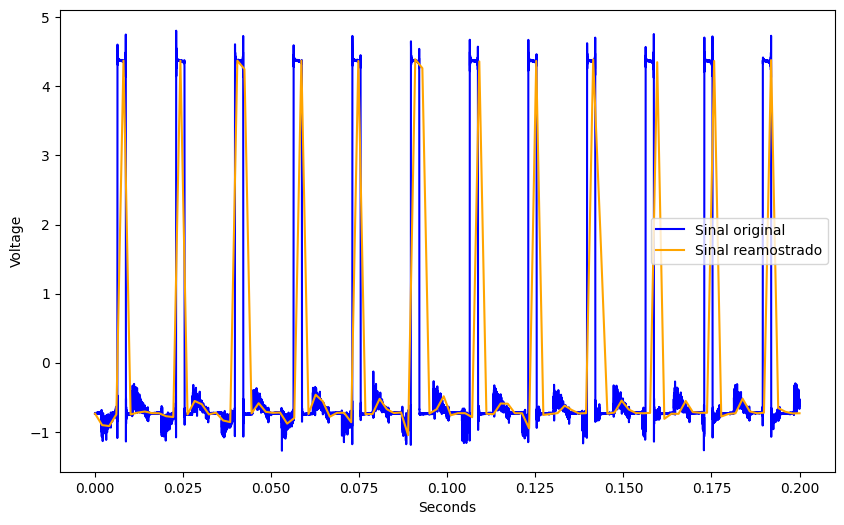

In [ ]:
resampled_signal, new_sampling_rate = resample_signal(sample_normal.to_numpy(), ORIGINAL_SAMPLE_RATE, target_rate)

time = 0.2 # s
qty_original_samples =  int(ORIGINAL_SAMPLE_RATE * time)
qty_resampled_sample = int(target_rate * time)
t1 = np.linspace(0, time, qty_original_samples)
t2 = np.linspace(0, time, qty_resampled_sample)
plt.figure(figsize=(10, 6))
plt.plot(t1,  sample_normal[0][0:qty_original_samples], label='Sinal original', color='blue')
plt.plot(t2,  resampled_signal[0:qty_resampled_sample, 0], label='Sinal reamostrado', color='orange')
plt.xlabel('Seconds')
plt.ylabel('Voltage')
plt.legend()

In [ ]:
a = normal_sample_resampled.to_numpy()

In [ ]:
print(a.max())

print(resampled_signal.max())

4.374949
4.5656


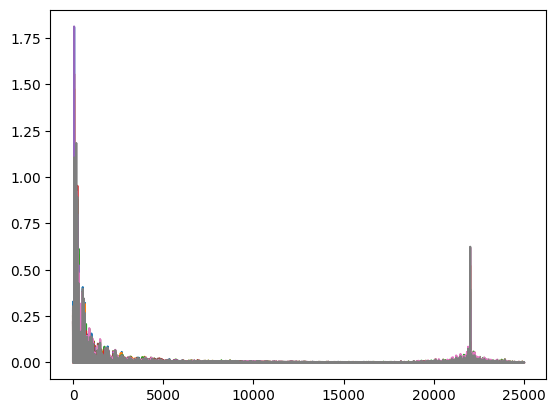

In [ ]:
# normal_sample_spectrum, xf = apply_fft(normalSample, ORIGINAL_SAMPLE_RATE)
# plt.plot(xf,normal_sample_spectrum)


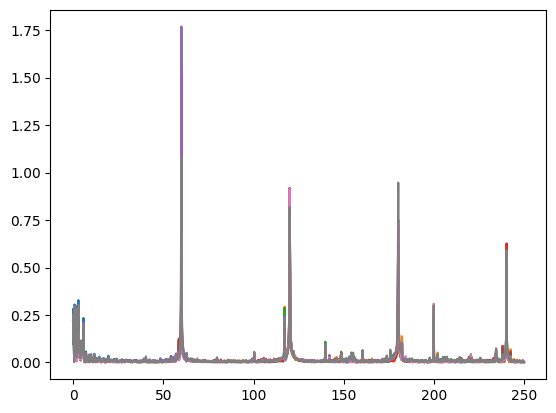

In [ ]:
# normal_sample_spectrum_resampled, xf_resampled = apply_fft(normalSampleResampled, target_rate)
# plt.plot(xf_resampled,normal_sample_spectrum_resampled)


In [ ]:
# imbalance6g_resample_spectrum, xf_imbalance6g_resampled = apply_fft(imbalance6gSampleResampled, target_rate)
# plt.plot(xf_imbalance6g_resampled, imbalance6g_resample_spectrum)

## processamento de dados
aqui os dados serão tratados para uso nos modelos de machine learn

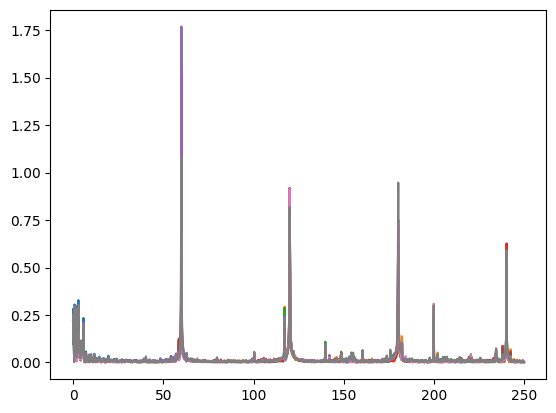

In [ ]:
normal_sample_spectrum_resampled, xf_resampled = apply_fft(normalSampleResampled, target_rate)
plt.plot(xf_resampled,normal_sample_spectrum_resampled)

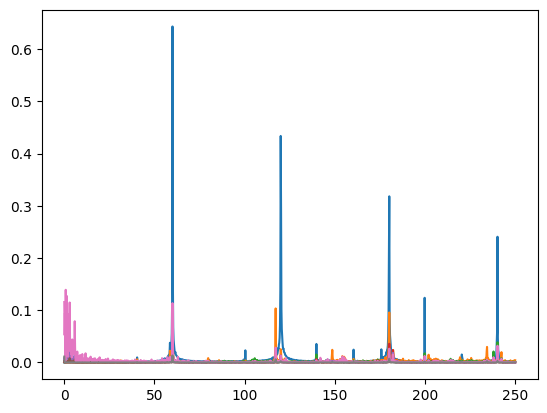

In [ ]:
normal_sample_spectrum_resampled_r, xf_resampled_r = apply_rfft(normalSampleResampled, target_rate)
plt.plot(xf_resampled_r, normal_sample_spectrum_resampled_r)

In [ ]:
def dataReader2d(path_names):
    data_n = pd.DataFrame()
    for i in path_names:
        low_data = pd.read_csv(i,header=None)
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return np.array(data_n)

In [ ]:
# def process_data(files_folder):
#     processed_data = []
#     # data = dataReader(files_folder)
#     # for i in range(len(data)):
#     #     data_resampled = resample(data[i], target_rate)
#     #     spectrum, xf = apply_fft(data_resampled, target_rate)
#     #     processed_data.append(spectrum)

#     data = dataReader2d(files_folder)
#     # dataScaled = scalerData(data)

#     data_resampled = resample(data, target_rate, len(files_folder))
#     spectrum, xf = apply_rfft(data_resampled, target_rate)
#     # processed_data.append(spectrum)

#     return spectrum


In [ ]:
from sklearn.preprocessing import StandardScaler

def scalerData(data):
  scaler = StandardScaler()
  scaled_data = scaler.fit_transform(data)
  return scaled_data

In [ ]:
qtt_undersampling = len(glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/normal/*.csv'))

In [ ]:
def process_data(files_folder):
    files_undersampled = np.random.choice(files_folder, qtt_undersampling, replace=False)
    data_resampled = np.empty((0, 8))
    print(files_undersampled)

    for i in range(len(files_undersampled)):
      data = pd.read_csv(files_undersampled[i], header=None)
      data = data.to_numpy();
      # file_resampled = resample(data, target_rate)
      file_resampled = resample_signal(data, ORIGINAL_SAMPLE_RATE, target_rate)
      data_resampled=np.vstack([data_resampled, file_resampled])

    # data_scaled = scalerData(data_resampled)
    spectrum, xf = apply_rfft(data_resampled, target_rate)

    return spectrum

In [30]:
def process_data_3d(files_folder):
  processed_data =[]

  for i in range(len(files_folder)):
    data = pd.read_csv(files_folder[i], header=None)
    data = data.to_numpy();
    signal_resampled = resample_signal(data, ORIGINAL_SAMPLE_RATE, target_rate)
    spectrum, xf = apply_rfft(signal_resampled, target_rate)

    processed_data.append( spectrum)

  return np.array(processed_data)

In [31]:
data_normal_3d = process_data_3d( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/normal/*.csv'))

In [32]:
data_normal_3d.shape

(49, 1750, 8)

In [ ]:
data_normal = process_data( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/normal/*.csv'))
data_imbalance= process_data( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/imbalance/**/*.csv'))

In [ ]:
print(np.max(data_normal, axis=0))
print(np.min(data_normal, axis=0))

[ 2763.25924961  8650.09230999  3581.09368077  1745.23569839
  9083.2011694   5367.70121369 10286.14225595  5665.2574361 ]
[0.28559823 0.43218138 1.06371732 0.37080388 0.822139   0.21945448
 0.31786348 0.4126748 ]


max e min de data_normal sem scaler

[4726.63002319 5585.8724479  1223.15785104  313.31038018 5672.2086244
  186.06709562 4225.61566487  638.64240249]

[0.48852353 0.27908489 0.36332314 0.06656792 0.51340313 0.00760722
 0.13058043 0.04652068]

 ---------------------------

 max e min de data_normal com scaler

 [ 2763.25924961  8650.09230999  3581.09368077  1745.23569839
  9083.2011694   5367.70121369 10286.14225595  5665.2574361 ]
  
[0.28559823 0.43218138 1.06371732 0.37080388 0.822139   0.21945448
 0.31786348 0.4126748 ]

In [34]:
import pickle
data_normal = process_data_3d( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/normal/*.csv'))
file_path = '/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/normal.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_normal, f)

data_imbalance= process_data_3d( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/imbalance/**/*.csv'))
file_path = '/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/imbalance.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_imbalance, f)

data_underhang = process_data_3d( glob.glob('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/data/underhang/**/*.csv', recursive=True))
file_path = '/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/underhang.pkl'
with open(file_path, 'wb') as f:
   pickle.dump(data_underhang, f)


In [3]:
import pickle
# data_normal = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data undersampling/normal.pkl', 'rb'))
# data_imbalance = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data undersampling/imbalance.pkl', 'rb'))
# data_underhang = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data undersampling/underhang.pkl', 'rb'))
data_normal = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data/normal.pkl', 'rb'))
data_imbalance = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data/imbalance.pkl', 'rb'))
data_underhang = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data/underhang.pkl', 'rb'))

data_normal_3d = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/normal.pkl', 'rb'))
data_imbalance_3d = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/imbalance.pkl', 'rb'))
data_underhang_3d = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/processed data 3d/underhang.pkl', 'rb'))

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = np.concatenate((
    data_normal,
    data_imbalance,
    data_underhang
    ), axis=0)

y_classes = np.concatenate((
    np.full(data_normal.shape[0], 'normal'),
    np.full(data_imbalance.shape[0], 'imbalance'),
    np.full(data_underhang.shape[0], 'underhang')
    ), axis=0)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_classes)


X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=1)

In [40]:
data_underhang_3d.shape

(558, 1750, 8)

In [41]:
X_3d.shape

(940, 1750, 8)

In [42]:
y_classes_3d.shape

(940,)

In [43]:
y_3d.shape

(1645000,)

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_3d = np.concatenate((
    data_normal_3d,
    data_imbalance_3d,
    data_underhang_3d
    ), axis=0)

y_classes_3d = np.concatenate((
    np.full(data_normal_3d.shape[0], 'normal'),
    np.full(data_imbalance_3d.shape[0], 'imbalance'),
    np.full(data_underhang_3d.shape[0], 'underhang')
    ), axis=0)

label_encoder_3d = LabelEncoder()
y_3d = label_encoder_3d.fit_transform(y_classes_3d)


X_train_3d, X_test_3d, y_train_3d, y_test_3d  = train_test_split(X_3d, y_3d, random_state=1)

In [45]:
X_train_3d.shape

(705, 1750, 8)

# SVM

In [5]:
import cupy as cp

X_train_cupy = cp.asarray(X_train)
y_train_cupy = cp.asarray(y_train)
X_test_cupy = cp.asarray(X_test)
y_test_cupy = cp.asarray(y_test)

NameError: name 'X_train' is not defined

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE

k_best = SelectKBest(score_func=f_classif, k=7)
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)
print("Features selecionadas por SelectKBest:", k_best.get_support(indices=True))

Features selecionadas por SelectKBest: [1 2 3 4 5 6 7]


In [ ]:
X_train_kbest_cupy = cp.asarray(X_train_kbest)
X_test_kbest_cupy = cp.asarray(X_test_kbest)

In [ ]:
%%time
from cuml import SVC

svc = SVC(random_state=1, C=100, gamma='scale', kernel='rbf')
svc.fit(X_train_kbest_cupy, y_train_cupy)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train_kbest_cupy, y_train_cupy)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test_kbest_cupy, y_test_cupy)))

usando selectkbest = 6

SVM accuracy is 0.9714104533195496 on Train Dataset

SVM accuracy is 0.9712154269218445 on Test Dataset

---------
usando selectkbezt = 7
SVM accuracy is 0.9848310947418213 on Train Dataset

SVM accuracy is 0.9846764206886292 on Test Dataset

CPU times: user 4min 59s, sys: 3min 31s, total: 8min 30s

Wall time: 8min 27s

In [ ]:
%%time
from cuml import SVC

svc = SVC(random_state=1, C=100, gamma='scale', kernel='rbf')
svc.fit(X_train_cupy, y_train_cupy)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train_cupy, y_train_cupy)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test_cupy, y_test_cupy)))

SVM accuracy is 0.9809160232543945 on Train Dataset
SVM accuracy is 0.9784957766532898 on Test Dataset
CPU times: user 19.5 s, sys: 1.63 s, total: 21.2 s
Wall time: 23.6 s


svc com normal, imbalance, vertical e horizontal

SVM accuracy is 0.8778060674667358 on Train Dataset

SVM accuracy is 0.8755038976669312 on Test Dataset

-----------------------
svc com normal, imbalance, vertical e horizontal com class-weght=balanced

SVM accuracy is 0.8692311644554138 on Train Dataset

SVM accuracy is 0.8671038746833801 on Test Dataset

---------------------------

svc com normal,, imbalance,  underhang - sem downsampling
tempo de execução 1m

SVM accuracy is 0.9927797317504883 on Train Dataset

SVM accuracy is 0.9924328327178955 on Test Dataset

----------------------

svc com normal, imbalance, underhang e overhang - sem downsampling
tempo de execução 10 m

SVM accuracy is 0.9875520467758179 on Train Dataset

SVM accuracy is 0.9870549440383911 on Test Dataset


--------

svc com normal, imbalance, underhang e overhang - sem downsampling - class-weght=balanced
tempo de execução 10 m

SVM accuracy is 0.9867780804634094 on Train Dataset

SVM accuracy is 0.9861960411071777 on Test Dataset

-------------------------------

svc com normal, imbalance, underhang - sem downsampling - GPU l4

SVM accuracy is 0.9927797317504883 on Train Dataset

SVM accuracy is 0.9924352765083313 on Test Dataset

CPU times: user 46.6 s, sys: 21.2 s, total: 1min 7s

Wall time: 1min 7s

In [ ]:
%%time
from sklearn.svm import SVC
svc = SVC(random_state=1, C=100, gamma='scale', kernel='rbf')
svc.fit(X_train, y_train)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train,y_train)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test,y_test)))

SVM accuracy is 0.9807450100291805 on Train Dataset
SVM accuracy is 0.978231461757343 on Test Dataset
CPU times: user 4min 8s, sys: 302 ms, total: 4min 8s
Wall time: 4min 7s


normal e todos imbalance

SVM accuracy is 0.9967090501121915 on Train Dataset

SVM accuracy is 0.9964637247569185 on Test Dataset

--------------------------
normal e todos imbalance com class_weight='balanced'

SVM accuracy is 0.994640737970581 on Train Dataset

SVM accuracy is 0.9944412864622288 on Test Dataset

---------------------
normal , imbalance, undehang - com downsampling - CPU

SVM accuracy is 0.9807450100291805 on Train Dataset

SVM accuracy is 0.978231461757343 on Test Dataset

CPU times: user 4min 8s, sys: 302 ms, total: 4min 8s
Wall time: 4min 7s


In [ ]:
import pickle

with open('/content/drive/MyDrive/Colab Notebooks/data science/data-science-tcc/models/svc-model.pkl', 'wb') as file:
  pickle.dump(svc, file)

In [ ]:
# import dask.array as da
# # Converter arrays cupy para dask
# X_train_da = da.from_array(X_train_cupy, chunks=(1000, 20))
# y_train_da = da.from_array(y_train_cupy, chunks=(1000,))

# X_test_da = da.from_array(X_test_cupy, chunks=(1000, 20))
# y_test_da = da.from_array(y_test_cupy, chunks=(1000,))

In [ ]:
from sklearn.metrics import accuracy_score
from cuml.svm import SVC

def manual_grid_search(X_train, y_train, X_test, y_test, param_grid):
    best_score = 0
    best_params = None
    best_model = None
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:
                params = {'C': C, 'gamma': gamma, 'kernel': kernel}
                svc = SVC(**params)
                svc.fit(X_train, y_train)
                y_pred = svc.predict(X_test)
                score = accuracy_score(y_test, y_pred)
                if score > best_score:
                    best_score = score
                    best_params = params
                    best_model = svc
    return best_score, best_params

In [ ]:
from cuml.metrics import accuracy_score
import random

def select_random_params(dictionary):
  return {key: random.choice(value) for key, value in dictionary.items()}

def randomized_search_cv(model_class, param_dist, X_train, y_train, X_test, y_test, n_iter=50, scoring=accuracy_score):
    best_score = 0
    best_params = None
    best_model = None

    for _ in range(n_iter):
        print(f"Iteration {_ + 1}/{n_iter}")
        params = select_random_params(param_dist)
        print(f"params: {params}")
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = scoring(y_test, y_pred)
        print(f"score: {score}")

        if score > best_score:
            best_score = score
            best_params = params
            best_model = model

    return best_model, best_params, best_score


In [ ]:
%%time

from cuml import SVC
from cuml.metrics import accuracy_score
# param_dist = {
#     'C': [1, 10, 100],
#     'gamma': [1, 0.1, 0.001, 'scale'],
#     'kernel': ['linear', 'rbf', 'poly']
# }
param_dist = {
    'C': [1, 10, 100],
    'gamma': [ 'scale'],
    'kernel': ['rbf', 'poly']
}
# svc = SVC()
best_model, best_params, best_score = randomized_search_cv(
    SVC,
    param_dist,
    X_train_cupy,
    y_train_cupy,
    X_test_cupy,
    y_test_cupy,
    n_iter=3,
    scoring=accuracy_score
    )

print("Melhores hiperparâmetros: ", best_params)

print("Acuracidade no conjunto de treino: ", best_model.score(X_train_cupy, y_train_cupy))
print("Acuracidade no conjunto de teste: ", best_score)

Iteration 1/3
params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
score: 0.9605989456176758
Iteration 2/3
params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
score: 0.9784957766532898
Iteration 3/3
params: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}
score: 0.9657922983169556
Melhores hiperparâmetros:  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Acuracidade no conjunto de treino:  0.9809160232543945
Acuracidade no conjunto de teste:  0.9784957766532898
CPU times: user 8min 50s, sys: 7.75 s, total: 8min 58s
Wall time: 8min 56s


AJUSTE DE HYPERPAREMATRO

METODO RANDONIZED MANUAL COM OS SEGUINTES PARAMETROS

param_dist = {
    'C': [1, 10, 100],
    'gamma': [ 'scale'],
    'kernel': ['rbf', 'poly']
}

Iteration 1/3

params: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}

score: 0.9605989456176758

Iteration 2/3

params: {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}

score: 0.9657922983169556

Iteration 3/3

params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

score: 0.9784957766532898

Melhores hiperparâmetros:  {'C': 100, 'gamma': 'scale', 'kernel':
 'rbf'}

Acuracidade no conjunto de treino:  0.9809160232543945

Acuracidade no conjunto de teste:  0.9784957766532898

CPU times: user 8min 39s, sys: 7.33 s, total: 8min 46s Wall time: 8min 45s

In [ ]:
%%time

from cuml import SVC
from cuml.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    'C': [ 1, 10, 100],
    'gamma': ['scale', 0.00001,  0.000001],
    'kernel': ['rbf',  'poly']
}

svc = SVC()

grid_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy', verbose=3)
grid_search.fit(X_train, y_train)

print("Melhores hiperparâmetros: ", grid_search.best_params_)

print("Acuracidade no conjunto de treino: ", grid_search.best_estimator_.score(X_train_cupy, y_train_cupy))
print("Acuracidade no conjunto de teste: ",  grid_search.best_estimator_.score(X_test_cupy, y_test_cupy))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.975 total time=   1.9s
[CV 2/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.975 total time=   1.5s
[CV 3/3] END ......C=1, gamma=scale, kernel=rbf;, score=0.976 total time=   1.5s
[CV 1/3] END .....C=1, gamma=scale, kernel=poly;, score=0.947 total time=   8.3s
[CV 2/3] END .....C=1, gamma=scale, kernel=poly;, score=0.947 total time=   8.3s
[CV 3/3] END .....C=1, gamma=scale, kernel=poly;, score=0.949 total time=   9.0s
[CV 1/3] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.974 total time=   3.8s
[CV 2/3] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.974 total time=   3.8s
[CV 3/3] END ......C=1, gamma=1e-05, kernel=rbf;, score=0.975 total time=   3.8s


In [ ]:
X_train_cupy_fs = X_train_cupy[:,  [0, 1, 2, 3, 7]]
X_test_cupy_fs = X_test_cupy[:,  [0, 1, 2, 3, 7]]

In [ ]:
%%time
from cuml import SVC

# original rodou em 8s =  C=100, gamma='scale', kernel='rbf'
# 1m 34s  -> C=100, gamma=0.1, kernel='rbf' -> 0.33
# 1m 34s ->  C=100, gamma=1, kernel='rbf' ->0.33
# 4s -> C=1, gamma='scale', kernel='rbf' -< 0.97
svc = SVC(random_state=1, C=1, gamma=1e-05, kernel='poly')
svc.fit(X_train_cupy, y_train_cupy)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train_cupy, y_train_cupy)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test_cupy, y_test_cupy)))

In [ ]:
%%time
from cuml import SVC

svc = SVC(random_state=1, C=100, gamma='scale', kernel='rbf')
svc.fit(X_train_cupy_fs, y_train_cupy)
print("SVM accuracy is {} on Train Dataset".format(svc.score(X_train_cupy_fs, y_train_cupy)))
print("SVM accuracy is {} on Test Dataset".format(svc.score(X_test_cupy_fs, y_test_cupy)))

SVM accuracy is 0.8949968218803406 on Train Dataset
SVM accuracy is 0.8924323320388794 on Test Dataset
CPU times: user 44.7 s, sys: 7.21 s, total: 51.9 s
Wall time: 51.7 s


utilizando todas as features

```
SVM accuracy is 0.9809160232543945 on Train Dataset
SVM accuracy is 0.9784957766532898 on Test Dataset
CPU times: user 7.35 s, sys: 1.15 s, total: 8.5 s
Wall time: 8.46 s
```




não utilizando as features dos sensores de overhang

```
SVM accuracy is 0.8949968218803406 on Train Dataset
SVM accuracy is 0.8924323320388794 on Test Dataset
CPU times: user 44.7 s, sys: 7.21 s, total: 51.9 s
Wall time: 51.7 s
```



In [ ]:
print(random_search.best_estimator_.score(X_train, y_train))
print(random_search.best_estimator_.score(X_test, y_test))

0.9792885780334473
0.977702796459198


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, classification_report
import seaborn as sns

def plot_model_performance(y_test, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues',cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
    print(class_report_df)

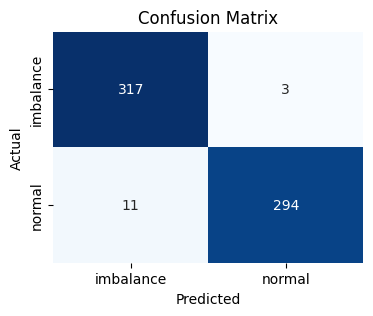

              precision    recall  f1-score   support
0              0.966463  0.990625  0.978395  320.0000
1              0.989899  0.963934  0.976744  305.0000
accuracy       0.977600  0.977600  0.977600    0.9776
macro avg      0.978181  0.977280  0.977570  625.0000
weighted avg   0.977900  0.977600  0.977589  625.0000


In [ ]:
y_pred = svc.predict(X_test)

plot_model_performance(y_test, y_pred, label_encoder.classes_)

In [ ]:
 np.count_nonzero(y == 0)

1250

  0%|          | 0/100 [00:00<?, ?it/s]

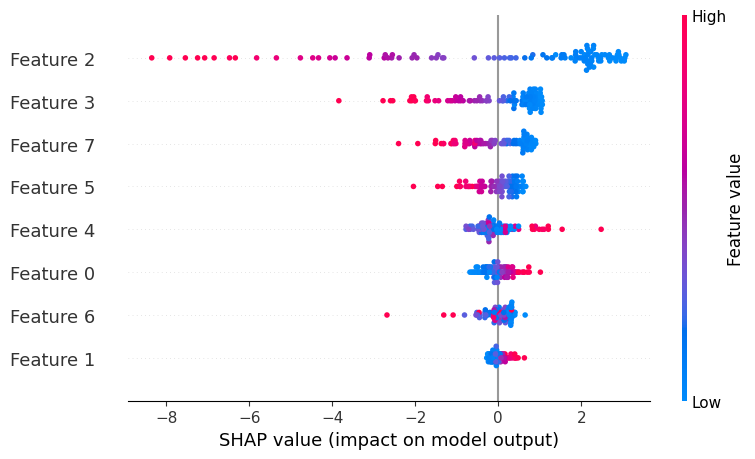

In [ ]:
import shap

X_train_sample = shap.sample(X_train, 100)

explainer = shap.KernelExplainer(best_svc.decision_function, X_train_sample)
# Calcular os valores SHAP
shap_values = explainer.shap_values(X_train_sample)

# Visualizar a importância das features
shap.summary_plot(shap_values, X_train_sample)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


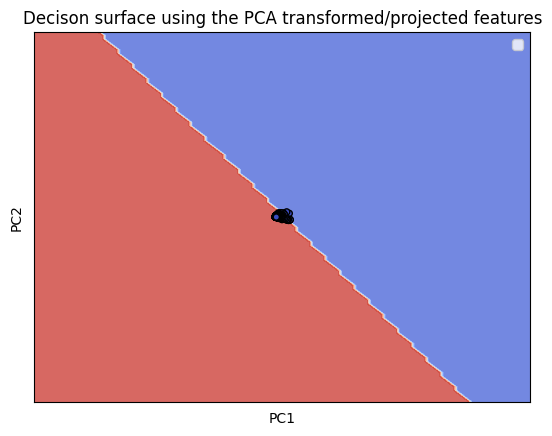

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
Xreduced = pca.fit_transform(X)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
clf = model.fit(Xreduced, y)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decison surface using the PCA transformed/projected features')
ax.legend()
plt.show()

# KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3, metric='manhattan', weights='distance') #n_neighbors = k
knn.fit(X_train, y_train)
print("k={}NN Accuracy on Train Data: {}".format(3,knn.score(X_train, y_train)))
print("k={}NN Accuracy on Test Data: {}".format(3,knn.score(X_test, y_test)))

In [12]:
%%time
from cuml import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 7, metric='manhattan')
knn.fit(X_train_cupy, y_train_cupy)

print("k={}NN Accuracy on Train Data: {}".format(3,knn.score(X_train_cupy, y_train_cupy)))
print("k={}NN Accuracy on Test Data: {}".format(3,knn.score(X_test_cupy, y_test_cupy)))

k=3NN Accuracy on Train Data: 0.9900433421134949
k=3NN Accuracy on Test Data: 0.9871829748153687
CPU times: user 1min 16s, sys: 294 ms, total: 1min 16s
Wall time: 1min 16s


### KNN com indersampling
k=3NN Accuracy on Train Data: 0.9721878170967102

k=3NN Accuracy on Test Data: 0.965154767036438

CPU times: user 12.8 s, sys: 511 ms, total: 13.3 s

Wall time: 14.9 s

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from cuml import KNeighborsClassifier

param_grid = {
    'n_neighbors': [5, 7, 9, 11, 13],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Melhor estimador
best_knn = grid_search.best_estimator_

# Avaliar o modelo
print("Acuracidade no conjunto de treino: ", best_knn.score(X_train_cupy, y_train_cupy))
print("Acuracidade no conjunto de teste: ", best_knn.score(X_test_cupy, y_test_cupy))

[I] [18:03:14.575693] Unused keyword parameter: n_jobs during cuML estimator initialization
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[I] [18:03:14.627280] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.627831] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.628376] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.628739] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.629065] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.629374] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.629704] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.630023] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.630337] Unused keyword parameter: n_jobs during cuML estimator initialization
[I] [18:03:14.63065

### KNN com undersampling

Melhores hiperparâmetros:  {'metric': 'manhattan', 'n_neighbors': 7}

Acuracidade no conjunto de treino:  0.9721878170967102

Acuracidade no conjunto de teste:  0.965154767036438

CPU times: user 2.63 s, sys: 525 ms, total: 3.15 s

Wall time: 1min 17s

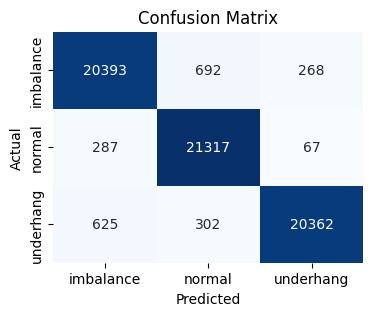

              precision    recall  f1-score       support
0              0.957193  0.955041  0.956116  21353.000000
1              0.955448  0.983665  0.969351  21671.000000
2              0.983814  0.956456  0.969942  21289.000000
accuracy       0.965155  0.965155  0.965155      0.965155
macro avg      0.965485  0.965054  0.965137  64313.000000
weighted avg   0.965417  0.965155  0.965153  64313.000000


In [ ]:
y_pred_knn = best_knn.predict(X_test_cupy)
# type(y_pred_knn)
y_pred_knn_cp = y_pred_knn.get()
plot_model_performance(y_test, y_pred_knn_cp, label_encoder.classes_)

In [85]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 72.9 MB/s eta 0:00:00


In [86]:
%%time
from cuml import KNeighborsClassifier
from dtaidistance import dtw
from cuml import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('dtw', dtw.DistanceTransformer()),  # Transformador para calcular a matriz de distâncias DTW
    ('knn', KNeighborsClassifier(metric='precomputed'))
])
param_grid = {
    'knn__n_neighbors': [5, 7, 9, 11, 13],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    # 'dtw__window': [5, 10] # parâmetro de janela do DTW (opcional)
}
# knn = KNeighborsClassifier()

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Melhor estimador
best_knn = grid_search.best_estimator_

# Avaliar o modelo
print("Acuracidade no conjunto de treino: ", best_knn.score(X_train_cupy, y_train_cupy))
print("Acuracidade no conjunto de teste: ", best_knn.score(X_test_cupy, y_test_cupy))

AttributeError: module 'dtaidistance.dtw' has no attribute 'DistanceTransformer'

In [11]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 26.1 MB/s eta 0:00:00


In [12]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier


# Definir o modelo KNN com DTW
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Treinar o modelo
knn_dtw.fit(X_train_3d, y_train_3d)

print("k={}NN Accuracy on Train Data: {}".format(3, knn_dtw.score(X_train_3d, y_train_3d)))
print("k={}NN Accuracy on Test Data: {}".format(3, knn_dtw.score(X_test_3d, y_test_3d)))


KeyboardInterrupt: 

# Gradient Boosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=1, learning_rate=0.1, max_depth=5, min_samples_split=2, n_estimators=300, subsample=0.8)
gbc.fit(X_train, y_train)
print("Gradient Boosting accuracy on Train Dataset: {}".format(gbc.score(X_train, y_train)))
print("Gradient Boosting accuracy on Test Dataset: {}".format(gbc.score(X_test, y_test)))

Gradient Boosting accuracy on Train Dataset: 0.9873067374324261
Gradient Boosting accuracy on Test Dataset: 0.9785579898309829


from sklearn.ensemble import GradientBoostingClassifier
17min

In [ ]:
%%time
# !pip install xgboost
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}
model = xgb.XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Melhores hiperparâmetros: ", grid_search.best_params_)
print("Gradient Boosting accuracy on Train Dataset: {}".format(best_model.score(X_train, y_train)))
print("Gradient Boosting accuracy on Test Dataset: {}".format(best_model.score(X_test, y_test)))


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:42] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:43] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:28:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:05] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:08] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:35] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:47] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:29:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:25] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:30:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:12] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:26] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:39] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:50] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:03] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:16] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:28] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:42] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:32:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:29] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:42] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:55] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:33:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:08] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:21] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:33] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:46] WARNING: /workspac

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:34:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:22] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:34] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:47] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:35:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:00] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:13] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:24] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:37] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:50] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   2.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:36:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:05] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:29] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:50] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:51] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:52] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:37:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:04] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:16] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:31] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:55] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:38:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:08] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:34] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:58] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:08] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:21] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:22] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:35] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:48] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:40:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:13] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:25] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:39] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:51] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:41:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:03] WARNING: /workspac

[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:15] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:26] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:27] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:40] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:52] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:05] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:17] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:30] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.5; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:43:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   3.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:10] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=1.0; total time=   3.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:30] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:31] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:44] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:45] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:57] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:44:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:09] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:22] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:44] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:47] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:45:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.5; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=0.7; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:36] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.5; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=0.7; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:46:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.6s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.5; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:14] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=0.7; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=6, n_estimators=200, subsample=1.0; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.5; total time=   0.8s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:28] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=0.7; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=50, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:40] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.5; total time=   1.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=0.7; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:52] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=100, subsample=1.0; total time=   1.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:47:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.5; total time=   2.4s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:07] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=0.7; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:18] WARNING: /workspac

[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.3s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.1s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.2s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=9, n_estimators=200, subsample=1.0; total time=   2.1s
Melhores hiperparâmetros:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}
Gradient Boosting accuracy on Train Dataset: 0.9856844462181956
Gradient Boosting accuracy on Test Dataset: 0.979273241801813
CPU times: user 38min 57s, sys: 25.6 s, total: 39min 23s
Wall time: 20min 12s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:48:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


### GB com undersampling
Melhores hiperparâmetros:

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Gradient Boosting accuracy on Train Dataset: 0.9856844462181956

Gradient Boosting accuracy on Test Dataset: 0.979273241801813

CPU times: user 38min 57s, sys: 25.6 s, total: 39min 23s

In [14]:
import xgboost as xgb
gxb = xgb.XGBClassifier(colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 6, n_estimators= 200, subsample= 1.0)
gxb.fit(X_train, y_train)
print("Gradient Boosting accuracy on Train Dataset: {}".format(gxb.score(X_train, y_train)))
print("Gradient Boosting accuracy on Test Dataset: {}".format(gxb.score(X_test, y_test)))

Gradient Boosting accuracy on Train Dataset: 0.9937888551165147
Gradient Boosting accuracy on Test Dataset: 0.9926711246200608


### GB sem undersampling
Gradient Boosting accuracy on Train Dataset: 0.9937888551165147

Gradient Boosting accuracy on Test Dataset: 0.9926711246200608

19s

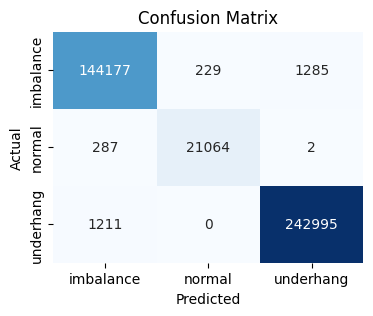

              precision    recall  f1-score        support
0              0.989717  0.989608  0.989662  145691.000000
1              0.989245  0.986466  0.987853   21353.000000
2              0.994731  0.995041  0.994886  244206.000000
accuracy       0.992671  0.992671  0.992671       0.992671
macro avg      0.991231  0.990372  0.990801  411250.000000
weighted avg   0.992670  0.992671  0.992671  411250.000000


In [17]:
y_pred_gxb = gxb.predict(X_test)
plot_model_performance(y_test, y_pred_gxb, label_encoder.classes_)

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}

# Inicializar o modelo Gradient Boosting
gb = GradientBoostingClassifier()

# Configurar a busca em grade
grid_search = GridSearchCV(gb, param_grid, cv=5, verbose=2, n_jobs=-1)

# Executar a busca em grade
grid_search.fit(X_train, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", grid_search.best_params_)

# Melhor estimador
best_gb = grid_search.best_estimator_

# Avaliar o modelo
print("Acuracidade no conjunto de treino: ", best_gb.score(X_train, y_train))
print("Acuracidade no conjunto de teste: ", best_gb.score(X_test, y_test))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Melhores hiperparâmetros:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.8}
Acuracidade no conjunto de treino:  1.0
Acuracidade no conjunto de teste:  0.9904153354632588


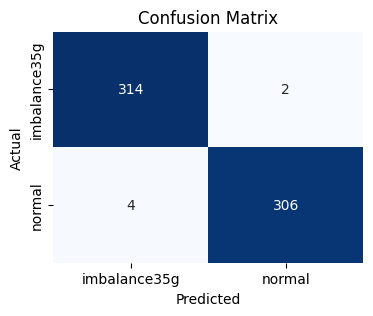

              precision    recall  f1-score     support
0              0.987421  0.993671  0.990536  316.000000
1              0.993506  0.987097  0.990291  310.000000
accuracy       0.990415  0.990415  0.990415    0.990415
macro avg      0.990464  0.990384  0.990414  626.000000
weighted avg   0.990435  0.990415  0.990415  626.000000


In [ ]:
y_pred_gb = best_gb.predict(X_test)

plot_model_performance(y_test, y_pred_gb, label_encoder.classes_)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=2)
model = Sequential()

model.add(Dense(32, activation='relu', input_shape=(8,),kernel_initializer='random_uniform'))
model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(128, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(64, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(32, activation='relu',kernel_initializer='random_uniform'))
model.add(Dense(7, activation='softmax',kernel_initializer='random_uniform'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 32)                288       
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 128)               8320      
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 7)                 231       
                                                                 
Total params: 21287 (83.15 KB)
Trainable params: 2128

In [ ]:
hist = model.fit(X_train , y_train , epochs=20, validation_split=0.2)

Epoch 1/20
47/47 [==============================] - 5s 18ms/step - loss: 1.8220 - accuracy: 0.5000 - val_loss: 1.3778 - val_accuracy: 0.4920
Epoch 2/20
47/47 [==============================] - 0s 10ms/step - loss: 0.8023 - accuracy: 0.5187 - val_loss: 0.6958 - val_accuracy: 0.5080
Epoch 3/20
47/47 [==============================] - 0s 8ms/step - loss: 0.6960 - accuracy: 0.5120 - val_loss: 0.6942 - val_accuracy: 0.5080
Epoch 4/20
47/47 [==============================] - 0s 7ms/step - loss: 0.6949 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.5080
Epoch 5/20
47/47 [==============================] - 1s 12ms/step - loss: 0.6962 - accuracy: 0.4907 - val_loss: 0.6938 - val_accuracy: 0.5080
Epoch 6/20
47/47 [==============================] - 1s 15ms/step - loss: 0.6945 - accuracy: 0.4827 - val_loss: 0.6933 - val_accuracy: 0.5080
Epoch 7/20
47/47 [==============================] - 0s 8ms/step - loss: 0.6969 - accuracy: 0.4880 - val_loss: 0.6959 - val_accuracy: 0.5080
Epoch 8/20
47/47

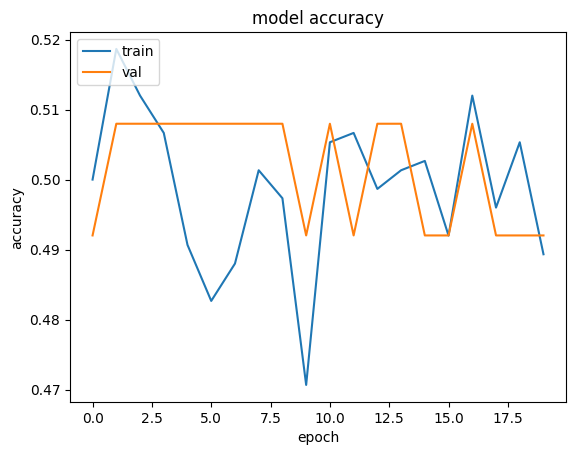

In [ ]:

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# LSTM

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [69]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [11]:
!pip install scikeras

como foi aplicado fft, os dados não tem mais informações temporais, ou seja a ordem dos dados não é mais importante, por isso foi usado a validação cruzada apenas definindo o parametro cv no gridsearchcv, não necessitando do TimeSeriesSplit

In [83]:
%%time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

n_samples, timesteps, features = X_train_3d.shape

def create_lstm_model(lstm_units, optimizer, activation, dense_units):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))
    model.add(LSTM(units=lstm_units))
    model.add(Dense(units=dense_units,  activation=activation))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = KerasClassifier(model=create_lstm_model, verbose=1, epochs=10)

param_grid = {
    'model__lstm_units': [50, 100, 200],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__activation':['relu', 'tanh', 'softmax'],
    'model__dense_units':[3, 6, 12]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Executa a busca em grade
grid_result = grid.fit(X_train_3d, y_train_3d)

print("Melhores parâmetros: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.48652482 0.49787234 0.41985816 0.38723404 0.49503546 0.37021277
        nan        nan 0.55602837        nan        nan        nan
        nan        nan 0.7177305         nan 0.60425532        nan
 0.71205674 0.54326241 0.64113475 0.53333333 0.52340426 0.43829787
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.9177305  0.90070922 0.95035461 0.94893617 0.95460993 0.97163121
 0.9106383  0.89787234 0.94468085 0.96595745 0.93333333 0.96453901
 0.90921986 0.90638298 0.96028369 0.94609929 0.93758865 0.96453901]
  warni

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7077 - loss: 0.6682
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9024 - loss: 0.2695
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9425 - loss: 0.1775
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9444 - loss: 0.1356
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9663 - loss: 0.1015
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9780 - loss: 0.0700
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9815 - loss: 0.0581
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9533 - loss: 0.1821
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9888 - loss: 0.0424
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9963 - loss: 0.0219
Melhores parâmetros: 0.971631 usando {'model__activation': 'softmax', 'model__dense_units': 3, 'model__lstm_units': 200, 'model__optimizer': 'rmsprop

dados 3d sem undersampling

Melhores parâmetros: 0.971631 usando {'model__activation': 'softmax', 'model__dense_units': 3, 'model__lstm_units': 200, 'model__optimizer': 'rmsprop'}

CPU times: user 20.8 s, sys: 1.95 s, total: 22.7 s

Wall time: 15min 25s

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train_3d = np.expand_dims(X_train, axis=1)
X_test_3d = np.expand_dims(X_test, axis=1)


model = Sequential()
model.add(LSTM(50, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Treinar o modelo
model.fit(X_train_3d, y_train, epochs=100, batch_size=100, validation_data=(X_test_3d, y_test))

# Avaliar o modelo
loss = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

# CNN


In [88]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import keras_tuner as kt


# def model_builder(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Conv2D(
#       filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
#       kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
#       activation='relu',
#       input_shape=(28, 28, 1)
#   ))


n_samples, timesteps, features = X_train_3d.shape

model = Sequential()
model.add(Input(shape=(timesteps, features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Para classificação com 3 classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train_3d, y_train_3d, epochs=20, batch_size=32, validation_data=(X_test_3d, y_test_3d))

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test_3d, y_test_3d)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.5710 - loss: 286.2437 - val_accuracy: 0.7872 - val_loss: 1.3849
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6715 - loss: 0.7881 - val_accuracy: 0.7404 - val_loss: 0.8059
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6994 - loss: 0.7057 - val_accuracy: 0.7447 - val_loss: 0.7955
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6554 - loss: 0.7520 - val_accuracy: 0.7574 - val_loss: 0.7635
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7180 - loss: 0.7336 - val_accuracy: 0.7404 - val_loss: 0.7296
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7033 - loss: 0.7081 - val_accuracy: 0.7872 - val_loss: 0.6974
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6981 - loss: 0.6920 - val_accuracy: 0.8043 - val_loss: 1.1823
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7698 - loss: 0.6252 - val_accuracy: 0.8085 - val_l

In [7]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_3d),
    y=y_train_3d
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)
print(class_weights_dict)

[0.92519685 6.35135135 0.56763285]
{0: 0.9251968503937008, 1: 6.351351351351352, 2: 0.5676328502415459}


In [32]:
%%time
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

n_samples, timesteps, features = X_train_3d.shape

def create_model(filters, kernel_size, pool_size, dense_units, activation_conv, activation_dense1, activation_dense2):
    model = Sequential()
    model.add(Input(shape=(timesteps, features)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation=activation_conv))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation_dense1))
    model.add(Dense(3, activation=activation_dense2))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(model=create_model, epochs=10, batch_size=32, verbose=2)

param_grid = {
    'model__filters': [32, 64],
    'model__kernel_size': [3, 5],
    'model__pool_size': [2, 3],
    'model__dense_units': [64, 128],
    'model__activation_conv':['relu', 'softmax'],
    'model__activation_dense1':['relu', 'softmax'],
    'model__activation_dense2':['relu', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(X_train_3d, y_train_3d, class_weight=class_weights_dict, validation_data=(X_test_3d, y_test_3d))

print("Melhores parâmetros: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Epoch 1/10
23/23 - 5s - 225ms/step - accuracy: 0.7745 - loss: 1.0172 - val_accuracy: 0.8894 - val_loss: 0.8581
Epoch 2/10
23/23 - 0s - 5ms/step - accuracy: 0.9333 - loss: 0.8767 - val_accuracy: 0.9702 - val_loss: 0.8129
Epoch 3/10
23/23 - 0s - 5ms/step - accuracy: 0.9716 - loss: 0.8182 - val_accuracy: 0.9574 - val_loss: 0.7851
Epoch 4/10
23/23 - 0s - 5ms/step - accuracy: 0.9872 - loss: 0.7855 - val_accuracy: 0.9660 - val_loss: 0.7491
Epoch 5/10
23/23 - 0s - 5ms/step - accuracy: 0.9929 - loss: 0.7564 - val_accuracy: 0.9660 - val_loss: 0.7295
Epoch 6/10
23/23 - 0s - 5ms/step - accuracy: 0.9943 - loss: 0.7317 - val_accuracy: 0.9787 - val_loss: 0.6969
Epoch 7/10
23/23 - 0s - 5ms/step - accuracy: 0.9957 - loss: 0.7066 - val_accuracy: 0.9830 - val_loss: 0.6755
Epoch 8/10
23/23 - 0s - 5ms/step - accuracy: 0.9972 - loss: 0.6847 - val_accuracy: 0.9745 - val_loss: 0.6565
Epoch 9/10
23/23 - 0s - 5ms/step - accuracy: 0.9972 - loss: 0.6638 - val_accuracy: 0.9745 - val_loss: 0.6354
Epoch 10/10
23/23

### CNN com todos os dados
Melhores parâmetros: 0.971631 usando {'model__activation_conv': 'softmax', 'model__activation_dense1': 'relu', 'model__activation_dense2': 'softmax', 'model__dense_units': 128, 'model__filters': 64, 'model__kernel_size': 3, 'model__pool_size': 3}

CPU times: user 21 s, sys: 6.01 s, total: 27.1 s

Wall time: 10min 18s

--------
### CCN com todos os dados + class_weight
Melhores parâmetros: 0.978723 usando {'model__activation_conv': 'softmax', 'model__activation_dense1': 'softmax', 'model__activation_dense2': 'softmax', 'model__dense_units': 64, 'model__filters': 64, 'model__kernel_size': 3, 'model__pool_size': 3}

CPU times: user 16.1 s, sys: 6.51 s, total: 22.7 s

Wall time: 10min 18s